# CAPSTONE PROJECT: Predicting Default Risk (Home Credit Group)

Patanin Kowittayawong (PK)<br>
BrainStation - Data Science Full Time Program<br>
December 14, 2018

<a id='01_projectoverview'></a>
## 1. Project Overview
---

Getting approved a financial loan without enough credit history is not an easy task, with such applicants often falling victim to untrustworthy lenders. In order to appropriately evaluate an applicant’s suitability for the loan, institutions such as Home Credit Group must consider alternative forms of data instead. This project aims to identify which of those available alternative data matters, and ultimately empowering such institutions with a model that can accurately evaluate their applicants' qualification status.

For the project, we will be using the full dataset from Kaggle's "Home Credit Default Risk" competition, available at:

[https://www.kaggle.com/c/home-credit-default-risk/data](https://www.kaggle.com/c/home-credit-default-risk/data "Kaggle: Home Credit Default Risk")

to create a model that predicts the probability of an applicant defaulting on his loan with Home Credit Group. We will be evaluating or model based on it's accuracy using the Area Under Curve (AUC) of the model's Receiver Operating Characteristic (ROC) curve.

Throughout the notebook's content below, I've detailed the different steps taken for this analysis alongside the written code itself. At each point where a model is trained and fitted, we will be running the model to predict on our Test dataset and outputing it as a csv file per the Kaggle competition's submission specifications to upload onto its leaderboard for a Test-Score.

<a id='01_01_tableofcontents'></a>
### 1.1 Analysis Process / Table of Contents

1. [Project Overview](#01_projectoverview)<br>
   1.1 [1.1 Analysis Process / Table of Contents](#01_01_tableofcontents)
2. [Notebook Setup](#02_nbsetup)<br>
   2.1 [Package Imports](#02_01_pkgimport)<br>
   2.2 [Raw Data](#02_02_rawdata)
3. [Exploratory Data Analysis | Cleaning | Pre-Processing](#03_eda)<br>
   3.1 [Target / Label Values](#03_01_targetvalues)<br>
   3.2 [Data Types / Formats](#03_02_datatypes)<br>
   3.3 [Missing Values / Nulls](#03_03_missingvalues)<br>
   3.4 [Outliers / Out-of-Range Values](#03_04_outliers)<br>
   3.5 [Encoding Categoricals](#03_05_catencoding)
4. [Baseline Model Fitting: Logistic Regression](#04_baselinelogreg)
5. [Improved Model Fitting: LightGBM](#05_lightgbmbaseline)
6. [Feature Engineering: FeatureTools](#06_featuretools)<br>
   6.1 [Trial #1: Deep Feature Synthesis](#06_01_dfs1)<br>
   6.2 [Trial #1: Model Fitting and Testing](#06_02_featuredtrain1)<br>
   6.3 [Trial #2: Deep Feature Synthesis (Entire Data Set)](#06_03_dfs2)
7. [Feature Selection (Part 1)](#07_featureselect1)<br>
   7.1 [FeatureTools selection.remove_low_information_features](#07_01_ftremovelowinfo)<br>
   7.2 [Removing SK_ID Related Features](#07_02_skidfeatures)<br>
   7.3 [Removing Collinearly Redundant Features](#07_03_collinearity)<br>
   7.4 [Removing High-Null-Density Features](#07_04_highnullfeatures)
8. [Trial #2: Model Fitting and Testing (Fully Feature Engineered Set)](#08_featuredtrain2)
9. [Feature Selection (Part 2): Zero-Importance Features](#09_featureselect2)
10. [Model Tuning: Hyper Parameter Optimization](#10_modeltuning)
11. [Evaluating Final Model Results](#11_finalevaluation)<br>
   11.1 [11.1 Plot: Receiver Operating Characteristic (ROC) / Area Under Curve (AUC)](#11_01_aucplot)<br>
   11.2 [11.2 Plot: Confusion Matrix](#11_02_confusionmatrix)<br>
   11.3 [11.3 Plot: Model Feature Importances](#11_03_finalfeatureimportance)<br>
   11.4 [11.4 Plot: EXT_SOURCE Scores](#11_04_externalsourcescores)<br>
   11.5 [11.5 Plot: Defaults over Age](#11_05_agedistribution)
12. [Future Work / Plans](#12_futurework)

<a id='02_nbsetup'></a>
## 2. Notebook Setup
---

<a id='02_01_pkgimport'></a>
### 2.1 Package Imports

Utility packages for general file management: `os`, `gc`, `warnings`<br>
Standard packages for data science analysis: `numpy`, `pandas`, `sklearn`<br>
Package for automated feature engineering: `featuretools`<br>
Package for LightGBM model: `lightgbm`<br>
Standard Packages for data visualization: `matplotlib.pyplot`, `seaborn`

In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Imputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc

import featuretools as ft
from featuretools import selection

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

<a id='02_02_rawdata'></a>
### 2.2 Raw Data

We take a quick glimpse at all the files we obtained from the Kaggle dataset (originally downloaded from the abovementioned link via their API).

In [2]:
raw_files = [_ for _ in os.listdir("../input/") if _!='.ipynb_checkpoints']
print("\033[1m\033[4mRaw/Input Data Files:\033[0m",*raw_files,sep='\n')

Raw/Input Data Files:
bureau_balance.csv
previous_application.csv
sample_submission.csv
application_test.csv
installments_payments.csv
HomeCredit_columns_description.csv
bureau.csv
application_train.csv
POS_CASH_balance.csv
credit_card_balance.csv


We see a total of 10 files in the dataset:
- "application_\[train/test\]" = our standard train and test set for model fitting and evaluation
- "HomeCredite_columns_description" = Full descriptions of each column data in our dataset
- The remaining 7 are supplemental tables we may join into our dataset for additional features

We will go ahead and load all 9 tables (excluding the columns_description file) and previewing them before performing any further analyses on them

In [3]:
raw_app_train = pd.read_csv('../input/application_train.csv')
print(f'application_train - Shape = {raw_app_train.shape}')
display(raw_app_train.head())

application_train - Shape = (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
raw_app_test = pd.read_csv('../input/application_test.csv')
print(f'application_test - Shape = {raw_app_test.shape}')
display(raw_app_test.head())

application_test - Shape = (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
raw_bureau = pd.read_csv('../input/bureau.csv')
print(f'bureau - Shape = {raw_bureau.shape}')
display(raw_bureau.head())

bureau - Shape = (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
raw_bureau_balance = pd.read_csv('../input/bureau_balance.csv')
print(f'bureau_balance - Shape = {raw_bureau_balance.shape}')
display(raw_bureau_balance.head())

bureau_balance - Shape = (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [7]:
raw_credit_card_balance = pd.read_csv('../input/credit_card_balance.csv')
print(f'credit_card_balance - Shape = {raw_credit_card_balance.shape}')
display(raw_credit_card_balance.head())

credit_card_balance - Shape = (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [8]:
raw_installments_payments = pd.read_csv('../input/installments_payments.csv')
print(f'installments_payments - Shape = {raw_installments_payments.shape}')
display(raw_installments_payments.head())

installments_payments - Shape = (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [9]:
raw_POS_CASH_balance = pd.read_csv('../input/POS_CASH_balance.csv')

print(f'POS_CASH_balance - Shape = {raw_POS_CASH_balance.shape}')
display(raw_POS_CASH_balance.head())

POS_CASH_balance - Shape = (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [10]:
raw_previous_application = pd.read_csv('../input/previous_application.csv')

print(f'previous_application - Shape = {raw_previous_application.shape}')
display(raw_previous_application.head())

previous_application - Shape = (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


<a id='03_eda'></a>
## 3. Exploratory Data Analysis | Cleaning | Pre-Processing
---

We begin our project analysis with running preliminary statistics on our data, visualizing some notable features, and correcting any problematic data points in order to obtain a dataset that can conform to our model functions' requirements.

<a id='03_01_targetvalues'></a>
### 3.1 Target / Label Values

We plot out our `TARGET` value counts and immediately see that there is a large gap between the number of records for those who have not defaulted (`TARGET` = 0) and those who did default (`TARGET` = 1). Our model will be facing an imbalanced class problem, hence we may have to tackle this issue by stratifying our train set later on when fitting models.

,COUNT(TARGET)
0,282686
1,24825


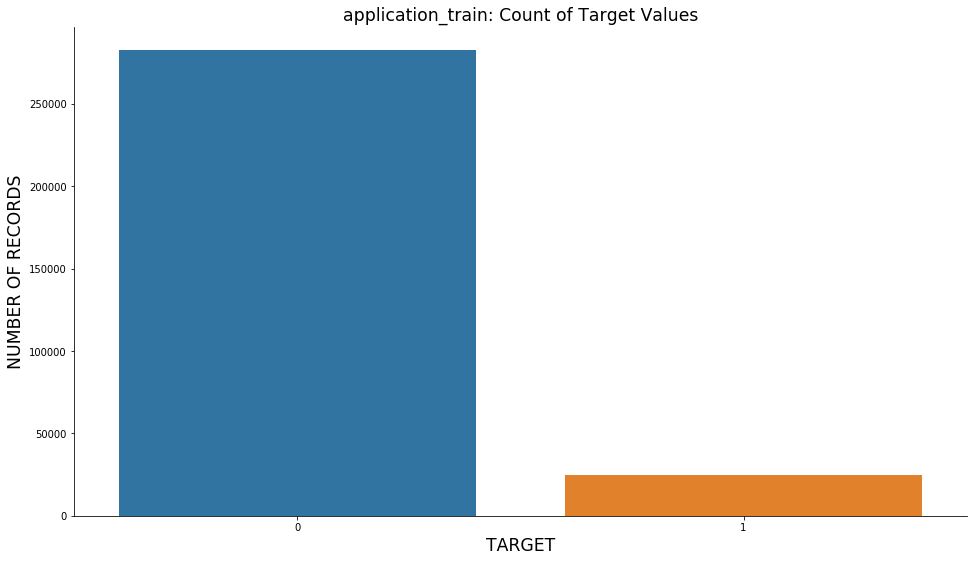

In [11]:
train_target_counts = raw_app_train['TARGET'].value_counts().rename('COUNT(TARGET)')

display(pd.DataFrame(train_target_counts))

plt.figure(figsize=(16,9))
sns.barplot(train_target_counts.keys(),train_target_counts)
sns.despine()
plt.title('application_train: Count of Target Values', fontsize='xx-large')
plt.xlabel('TARGET',fontsize='xx-large')
plt.ylabel('NUMBER OF RECORDS',fontsize='xx-large')
plt.show()

<a id='03_02_datatypes'></a>
### 3.2 Data Types / Formats

We then look at the breakdown of data types by each column, as any non-numeric column will have to be transformed before fitting the set into the model. We find a total of 16 columns within the train set containing categorical/text values. Each columns contains quite a varying number of domain values, ranging from as little as 2 up to 58.

In [12]:
display(pd.DataFrame(raw_app_train.dtypes.value_counts(),columns=['COUNT']))
display(pd.DataFrame(raw_app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0).sort_values(ascending=True),columns=['COUNT']))

,COUNT
float64,65
int64,41
object,16


,COUNT
NAME_CONTRACT_TYPE,2
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
EMERGENCYSTATE_MODE,2
CODE_GENDER,3
HOUSETYPE_MODE,3
FONDKAPREMONT_MODE,4
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6


Taking a look at the unique domain values under each of the above-listed non-numeric columns, we do see some columns have marked null values differently, e.g. with 'XNA' or with `np.nan`. Other than that, our dataset does not contain any duplicates or redundant/misspelled values. Hence, this will be one less issue that we have to worry about later.

In [13]:
for col in raw_app_train.select_dtypes('object'):
    print(f'\033[1m{col}:\033[0m\n{raw_app_train[col].unique()}')

NAME_CONTRACT_TYPE:
['Cash loans' 'Revolving loans']
CODE_GENDER:
['M' 'F' 'XNA']
FLAG_OWN_CAR:
['N' 'Y']
FLAG_OWN_REALTY:
['Y' 'N']
NAME_TYPE_SUITE:
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE:
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS:
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE:
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skil

We proceed to standardizing the null-representation of all columns by changing them all to `np.nan`.

In [14]:
for col in raw_app_train.select_dtypes('object'):
    if 'XNA' in raw_app_train[col].unique():
        raw_app_train[col].replace('XNA',np.nan,inplace=True)
        print(f'\033[1m{col} (NEW):\033[0m\n{raw_app_train[col].unique()}')

CODE_GENDER (NEW):
['M' 'F' nan]
ORGANIZATION_TYPE (NEW):
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' nan
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6']


<a id='03_03_missingvalues'></a>
### 3.3 Missing Values / Nulls

We then look at columns with missing or null values in our train set to get an idea of how much data we are missing. We calculate for the percentage of records that are missing that column's value, sorting it down from columns with the most to least number of records. These missing values will have to be accounted for and handled with before fitting our models to ensure that the nulls are not skewing it.

In [15]:
# Count number of nulls per column, divided by total number of records in train set, converted to % values
missing_vals_raw_app_train = pd.concat([raw_app_train.isnull().sum(),(100 * raw_app_train.isnull().sum() / len(raw_app_train))],axis=1)

# Sort above results by descending % values and filter out non-null columns 
missing_vals_raw_app_train = missing_vals_raw_app_train.rename(columns={0:"n_Nulls",1:"%_Nulls"}).sort_values(by=['%_Nulls'],ascending=False)
missing_vals_raw_app_train = missing_vals_raw_app_train[(missing_vals_raw_app_train["n_Nulls"]!=0)]

print(f'missing_vals_raw_app_train - Shape = {missing_vals_raw_app_train.shape}')
with pd.option_context("display.max_rows", 100):
    display(missing_vals_raw_app_train)

missing_vals_raw_app_train - Shape = (69, 2)


,n_Nulls,%_Nulls
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


<a id='03_04_outliers'></a>
### 3.4 Outliers | Out-of-Range Values

We use `describe` on our train set to get quick statistics on each column's set of values. We do a quick glance over each of the values to find 2 columns with interestingly odd metrics: `DAYS_BIRTH`,`DAYS_EMPLOYED`, `DAYS_REGISTRATION`, and `DAYS_PUBLSHED`.

For instance, with `DAYS_BIRTH`, we are looking at the applicants' ages, in days, as of the day they applied for the loan. All values within this column are negative. This turned out to be the standard format by which our dataset has recorded all forms of time, in the format of $T-n$, and applies to all the abovementioned columns. However, we will keep these values as-is knowing that our models should still be able to fit and handle negatives well as long as they remain on a standard scale.

In [16]:
with pd.option_context("display.max_columns", 200):
    display(raw_app_train.describe())

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

The next anomaly found was in `DAYS_EMPLOYED`, number of days applicant has been employed on his/her current job - we see a very large max value at 365,243. This value violates 2 principles: the negativity oftime values in this data set, and that the value itself translates to about 999.9 years ($365243 / 365.25 = 999.98$), something infeasible to any human. Plotting out the distribution of values below does show us that a large number of records actually have this value.

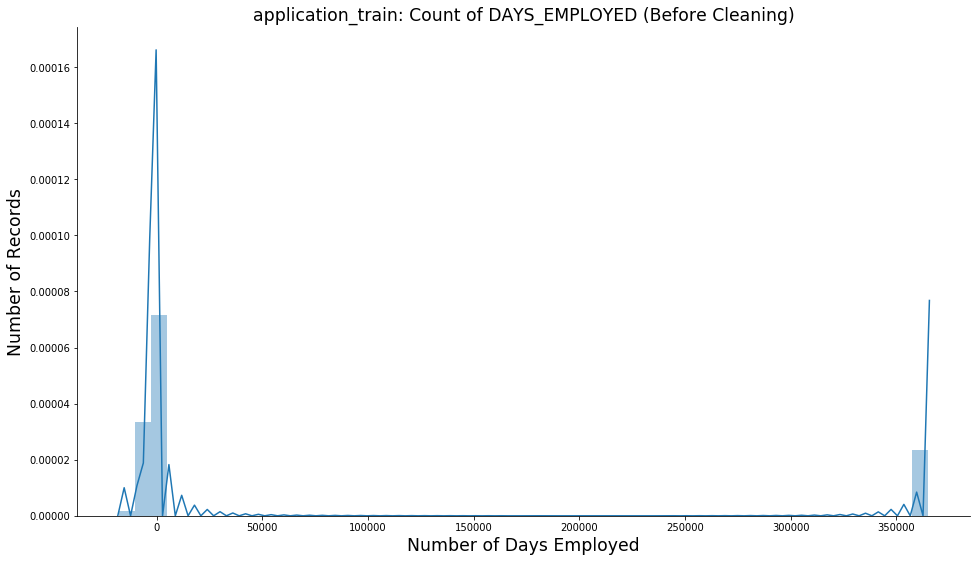

In [17]:
plt.figure(figsize=(16,9))
sns.distplot(raw_app_train['DAYS_EMPLOYED'])
sns.despine()
plt.title('application_train: Count of DAYS_EMPLOYED (Before Cleaning)', fontsize='xx-large')
plt.xlabel('Number of Days Employed',fontsize='xx-large')
plt.ylabel('Number of Records',fontsize='xx-large')
plt.show()

In thinking critically, the value 999.9 is indeed a very similar value to something one would put as a placeholder whenever such data containers do not allow non-numeric values. Suspecting that this may actually be an alternate way of storing nulls, we take to the Kaggle competition's own discussion board to look for answers, coming across an official confirmation from the host [here](https://www.kaggle.com/c/home-credit-default-risk/discussion/57247#332033, "Kaggle: Home Credit Default Risk - Positive DAYS_EMPLOYED") that this value is indeed representative of a null. Hence, we shall proceed to removing them from our dataset to ensure that the null-ness is retained.

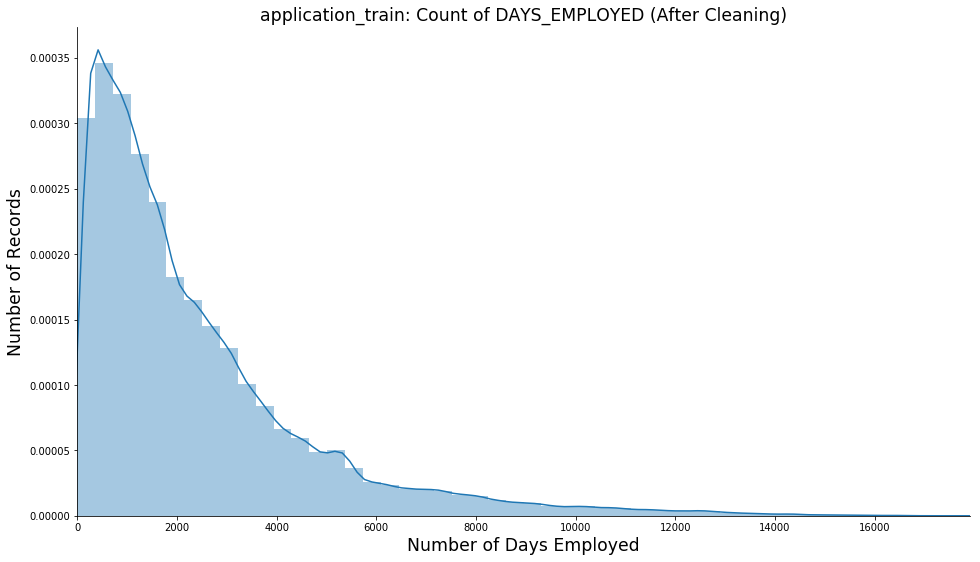

In [18]:
raw_app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
raw_app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

plt.figure(figsize=(16,9))
sns.distplot(-1*raw_app_train['DAYS_EMPLOYED'].dropna())
sns.despine()
plt.title('application_train: Count of DAYS_EMPLOYED (After Cleaning)', fontsize='xx-large')
plt.xlim(0,-1*raw_app_train['DAYS_EMPLOYED'].dropna().min())
plt.xlabel('Number of Days Employed',fontsize='xx-large')
plt.ylabel('Number of Records',fontsize='xx-large')
plt.show()

<a id='03_05_catencoding'></a>
### 3.5 Encoding Categoricals

Now that we have anomalies removed, we revisit our categorical columns to perform our last step of pre-processing before fitting a model - encoding categorical values. Our preference will be to One-Hot encode all our categorical values given its advantage in retaining the non-ordinal property of these categories, but we will occasionally use label encoding in any case where we have a column with 2 domain values as an effort to minimize the number of features/columns. Also, since we will be using this procedure often in our later analysis phases, we will be objectifying these codes to simplify our code.

In [19]:
def label_encode_train_test (raw_train, raw_test):    
    
    """
    Label encodes the TRAIN and TEST set for any non-numerical (dtype = object) columns that has only 2 unique/domain values.
    
    Args:
        raw_train (dataframe): TRAIN set to be label encoded
        raw_test (dataframe): TEST set to be label encoded
        
    Returns:        
        encoded_train (dataframe): Successfully label encoded TRAIN set
        encoded_test (dataframe): Successfully label encoded TEST set
    """
    
    # generate copy of datasets to retain original set
    encoded_train = raw_train.copy()
    encoded_test = raw_test.copy()

    # declare a label encoder and initiate counter of number of encoded columns
    label_encoder = LabelEncoder()
    label_encoded_cols = 0

    # loop through each column in set, determine if dtype=object and has 2 unique values or less, if yes - label encode 
    for col in encoded_train:
        if encoded_train[col].dtype == 'object':
            if encoded_train[col].nunique() <= 2:
                # If column has np.nans, temporarily replace with XNA to support label encoding 
                if encoded_train[col].isnull().sum()>0:
                    encoded_train[col].replace(np.nan,'XNA',inplace=True)
                    encoded_test[col].replace(np.nan,'XNA',inplace=True)

                
                #fit-transform train and test
                print(f'Label Encoding: {col}')
                encoded_train[col] = label_encoder.fit_transform(encoded_train[col])                    
                encoded_test[col] = label_encoder.transform(encoded_test[col])
                
                #If column had XNA, replace back to np.nan
                if 'XNA' in label_encoder.classes_:
                    encoded_train[col].replace(np.argwhere(label_encoder.classes_=='XNA'),np.nan, inplace=True)
                    encoded_train[col].replace(2,1, inplace=True)
                    encoded_test[col].replace(np.argwhere(label_encoder.classes_=='XNA'),np.nan, inplace=True)
                    encoded_test[col].replace(2,1, inplace=True)

                label_encoded_cols += 1

    print(f'{label_encoded_cols} columns were label encoded.')
    
    return encoded_train, encoded_test

In [20]:
def oh_encode_train_test (raw_train, raw_test):
    
    """
    One-hot encodes the TRAIN and TEST set for any non-numerical (dtype = object) columns.
    
    Args:
        raw_train (dataframe): TRAIN set to be label encoded
        raw_test (dataframe): TEST set to be label encoded
        
    Returns:        
        encoded_train (dataframe): Successfully label encoded TRAIN set
        encoded_test (dataframe): Successfully label encoded TEST set
    """
    
    # generate copy of datasets to retain original set
    encoded_train = raw_train.copy()
    encoded_test = raw_test.copy()

    # one-hot encode both Train and Test set
    encoded_train = pd.get_dummies(encoded_train)
    encoded_test = pd.get_dummies(encoded_test)

    print(f'One-Hot Encoding Completed. Train Shape = {encoded_train.shape}. Test Shape = {encoded_test.shape}')
    
    return encoded_train, encoded_test

In [21]:
def align_columns_train_test (raw_train, raw_test):
    
    """
    Aligns TRAIN with TEST set by dropping any columns unique to TRAIN and retaining only the commonly existing columns.
    Ensures that both sets have the same columns for model fitting and testing.
    
    Args:
        raw_train (dataframe): TRAIN set to be aligned
        raw_test (dataframe): TEST set to be aligned
        
    Returns:        
        encoded_train (dataframe): Successfully aligned TRAIN set
        encoded_test (dataframe): Successfully aligned TEST set
    """
    
    # generate copy of datasets to retain original set
    aligned_train = raw_train.copy()
    aligned_test = raw_test.copy()

    # temporarily store TARGET column for re-add later
    train_labels = aligned_train['TARGET']
    
    # run alignment
    aligned_train, aligned_test = aligned_train.align(aligned_test, join='inner', axis=1)

    # re-add TARGET column back into aligned train set
    aligned_train['TARGET'] = train_labels

    print(f'Train-Test Alignment Completed. Train Shape = {aligned_train.shape}. Test Shape = {aligned_test.shape}')

    return aligned_train, aligned_test

In [22]:
app_train_encoded, app_test_encoded = label_encode_train_test(raw_app_train, raw_app_test)
app_train_encoded, app_test_encoded = oh_encode_train_test(app_train_encoded, app_test_encoded)
app_train_encoded, app_test_encoded = align_columns_train_test(app_train_encoded, app_test_encoded)

Label Encoding: NAME_CONTRACT_TYPE
Label Encoding: CODE_GENDER
Label Encoding: FLAG_OWN_CAR
Label Encoding: FLAG_OWN_REALTY
Label Encoding: EMERGENCYSTATE_MODE
5 columns were label encoded.
One-Hot Encoding Completed. Train Shape = (307511, 239). Test Shape = (48744, 237)
Train-Test Alignment Completed. Train Shape = (307511, 237). Test Shape = (48744, 236)


From running our train and test sets through categorical encoding above, we've obtained a fully pre-processed and encoded train/test set, ready for some model fitting in the next phase.

<a id='04_baselinelogreg'></a>
## 4. Baseline Model Fitting: Logistic Regression
---

To begin with model fitting and testing, we start with a generic and simple model to obtain an initial "Baseline" score for comparing with any of our future modeling efforts. We will be fitting the above pre-processed dataset to a logistic regression and obtaining our baseline AUC score.

The any set will be dropping the `TARGET` column if it exists to generate the x set. The `TARGET` column will be returned as the y set instead.

To handle any null values within our set, we will be imputing them with medians. If the column/feature is a binary variable, we will impute with 0.5 (mid-point) between the 0 and 1.

We will then be scaling all variables with the Min-Max Scaler to transform our values into a confined range between 0 and 1. This should help our model with getting a proper fit.

Since we will be using this procedure of imputing and transforming often in our later model fits, both functions will be objectified.

In [23]:
def impute_scale_train_test(input_train, input_test):

    # drop TARGET if existing
    if 'TARGET' in input_train:
        y_train = input_train['TARGET']
        x_train = input_train.drop(columns = ['TARGET'])
    else:
        y_train = []
        x_train = input_train.copy()
        
    if 'TARGET' in input_test:
        y_test = input_test['TARGET']
        x_test = input_test.drop(columns = ['TARGET'])
    else:
        y_test = []
        x_test = input_test.copy()

    # extract feature names
    features_list = list(x_train.columns)
        
    # impute each binary variable with 0.5
    for col in x_train:
        if (x_train[col].nunique()) <= 2 and (x_train[col].isnull().sum()>0):
            x_train[col].replace(np.nan,0.5,inplace=True)
            x_test[col].replace(np.nan,0.5,inplace=True)
    
    # declare, fit, and transform median imputation of nulls - train & test
    imputer_median = Imputer(strategy = 'median')
    imputer_median.fit(x_train)
    x_train = imputer_median.transform(x_train)
    x_test = imputer_median.transform(x_test)

    # declare, fit, and transform MinMax Scaling - train & test
    scaler_minmax = MinMaxScaler(feature_range = (0, 1))
    scaler_minmax.fit(x_train)
    x_train = scaler_minmax.transform(x_train)
    x_test = scaler_minmax.transform(x_test)
    
    print('Median-Imputation and Min-Max Scaling completed:')
    print(f'x_train Shape = {x_train.shape}')
    print(f'x_test Shape = {x_test.shape}')
    if len(y_train)>0:
        print(f'y_train Shape = {y_train.shape}')
    if len(y_test)>0:
        print(f'y_test Shape = {y_test.shape}')

    return x_train, x_test, y_train, y_test, features_list

In [24]:
logreg_x_train, logreg_x_test, logreg_y_train, logreg_y_test, logreg_features_list = impute_scale_train_test(app_train_encoded, app_test_encoded)

/home/patanin_k/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Median-Imputation and Min-Max Scaling completed:
x_train Shape = (307511, 236)
x_test Shape = (48744, 236)
y_train Shape = (307511,)


With imputation and scaling completed, we then proceed with creating a Logistic Regression model and fitting it.

In [25]:
%%time
logreg = LogisticRegression(C = 0.0001, solver='lbfgs')
logreg.fit(logreg_x_train, logreg_y_train)

CPU times: user 11 s, sys: 344 ms, total: 11.3 s
Wall time: 3.23 s


Using the fitted model, we then generate predictions of the train set to check our accuracy.

In [26]:
logreg_pred_train = logreg.predict_proba(logreg_x_train)[:,1]
print(f' Baseline Logistic Regression - AUC Score (Train) = {roc_auc_score(logreg_y_train, logreg_pred_train)}')

 Baseline Logistic Regression - AUC Score (Train) = 0.693505412426225


The train AUC score for our baseline logistic regression model turned out at 0.694. It is surprisingly quite high already. We then generate predictions of the test set in the Kaggle competition's required submission format to validate our test AUC score.

In [27]:
logreg_pred_test = logreg.predict_proba(logreg_x_test)[:, 1]

submission = raw_app_test[['SK_ID_CURR']]
submission['TARGET'] = logreg_pred_test

submission.head()

,SK_ID_CURR,TARGET
0,100001,0.066693
1,100005,0.111204
2,100013,0.065054
3,100028,0.072192
4,100038,0.114288


In [28]:
submission.to_csv('../output/HomeCreditDefaultRisk_Submit001_LogRegBaseline.csv', index = False)

Our test predicions were submitted on 2018/12/14 07:03. Test AUC Score = 0.67419.

<a id='05_lightgbmbaseline'></a>
## 5. Improved Model Fitting: LightGBM
---

With a baseline model fitted and scored, we now proceed with trying a different that we believe should perform better on our dataset. From doing some research (for example, as explained in [this article](http://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/ "Machine Learning Explained: LightGBM and XGBoost Explained")), there is a unanimous agreement on the fact that Gradient Boosted Decision Trees are one of the best performing models currently available, especially when our dataset is in tabular form. Hence, we will try to implement Microsoft's LightGBM model to see if we can get more accurate predictions wiht it.

In training our LightGBM Model, we will also be applying cross-validation into our fitting in order to less variable scores. We've started with the standard K-Fold split per below. We will stick to 5 folds to balance between having enough folds versus keeping computation time low.

Per reference to [this article](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html "LightGBM Documentation: Parameters Tuning"), We should set the following parameters to achieve higher accuracy scores:

- Large `max_bin` values (although at the cost of computation time)
- Large `num_iterations`/`num_estimators` in conjunction with small `learing_rate` values
- Large `num_leaves` values (although at the cost over-fitting)

Given points 1 and 3 will have tradeoffs, we will omit those for now and only focust on `num_estimators` and `learning_rate`, setting them to 10,000 and 0.05 respectively.
    
To slightly improve computation time through the cross-validation folds, we will also apply a `bagging_fraction`/`subsample` at 0.85 to run each sample at 85% of data points from our full set per fold.  

In [29]:
def run_model_lightgbm(lgb_x_train, lgb_x_test, lgb_y_train, feature_names, lgb_k_fold, test_ids):

    # declare variables to store results
    lgb_feature_importance = np.zeros(len(feature_names))
    test_predictions = np.zeros(lgb_x_test.shape[0])
    out_of_fold = np.zeros(lgb_x_train.shape[0])
    val_scores = []
    train_scores = []
    if type(lgb_k_fold)==type(KFold(2)):
        k_fold_iterator = lgb_k_fold.split(lgb_x_train)
    if type(lgb_k_fold)==type(StratifiedKFold(2)):
        k_fold_iterator = lgb_k_fold.split(lgb_x_train,lgb_y_train)

    # loop through each fold in the CV
    for train_points, val_points in k_fold_iterator:
        
        fold_x_train, fold_y_train = lgb_x_train[train_points], lgb_y_train.iloc[train_points]
        fold_x_val, fold_y_val = lgb_x_train[val_points], lgb_y_train.iloc[val_points]
        
        # Initiate LightGBM model
        model_lgb = lgb.LGBMClassifier(n_estimators=10000, objective='binary',
                                       class_weight='balanced', learning_rate=0.05,
                                       reg_alpha=0.1, reg_lambda=0.1,
                                       subsample=0.85, n_jobs= -1, random_state=50)

        # fit model to train
        model_lgb.fit(fold_x_train, fold_y_train, eval_metric = 'auc',
                      eval_set = [(fold_x_val, fold_y_val), (fold_x_train, fold_y_train)],
                      eval_names = ['val', 'train'], categorical_feature = 'auto',
                      early_stopping_rounds = 100, verbose = 200)

        # record best iteration and use model iteration to predict validate and test sets
        fold_best_iteration = model_lgb.best_iteration_
        lgb_feature_importance += model_lgb.feature_importances_ / lgb_k_fold.n_splits

        test_predictions += model_lgb.predict_proba(lgb_x_test, num_iteration=fold_best_iteration)[:, 1] / lgb_k_fold.n_splits
        out_of_fold[val_points] = model_lgb.predict_proba(fold_x_val, num_iteration=fold_best_iteration)[:, 1]

        val_score = model_lgb.best_score_['val']['auc']
        train_score = model_lgb.best_score_['train']['auc']
        
        val_scores.append(val_score)
        train_scores.append(train_score)
        
        # save current model if it returned the highest val score
        if val_score >= max(val_scores):
            lgb_best_model = model_lgb
        
        # clear previous fold's model from memory
        gc.enable()
        del model_lgb, fold_x_train, fold_x_val
        gc.collect()

    # output model scores from all folds
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    lgb_feature_importances = pd.DataFrame({'feature': feature_names, 'importance': lgb_feature_importance})

    val_auc = roc_auc_score(lgb_y_train, out_of_fold)

    val_scores.append(val_auc)
    train_scores.append(np.mean(train_scores))

    fold_names = list(range(n_folds))
    fold_names.append('overall')

    metrics = pd.DataFrame({'fold': fold_names,
                                'train': train_scores,
                                'validate': val_scores})

    return lgb_best_model, metrics, lgb_feature_importances, submission

In [30]:
# obtain data sets
feature_names = logreg_features_list
lgb_x_train = np.array(logreg_x_train)
lgb_x_test = np.array(logreg_x_test)
# initiate K-Fold CV variable
n_folds = 5
lgb_k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=50)
lgb_y_train = raw_app_train['TARGET']
test_ids = raw_app_test['SK_ID_CURR']

lgb_best_model, lgb1_metrics, lgb_feature_importances, submission = run_model_lightgbm(lgb_x_train,
                                                                                       lgb_x_test,
                                                                                       lgb_y_train,
                                                                                       feature_names,
                                                                                       lgb_k_fold,
                                                                                       test_ids)

display(lgb1_metrics)

Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.754532	val's binary_logloss: 0.564271	train's auc: 0.796981	train's binary_logloss: 0.554412
Early stopping, best iteration is:
[250]	val's auc: 0.754908	val's binary_logloss: 0.559581	train's auc: 0.805016	train's binary_logloss: 0.547494
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.757146	val's binary_logloss: 0.564908	train's auc: 0.796755	train's binary_logloss: 0.554851
Early stopping, best iteration is:
[258]	val's auc: 0.757347	val's binary_logloss: 0.559337	train's auc: 0.806128	train's binary_logloss: 0.546682
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.76282	val's binary_logloss: 0.565217	train's auc: 0.795465	train's binary_logloss: 0.556084
Early stopping, best iteration is:
[294]	val's auc: 0.763052	val's binary_logloss: 0.556233	train's auc: 0.810461	train's binary_logloss: 0.543227
Training until validation scores do

,fold,train,validate
0,0,0.805016,0.754908
1,1,0.806128,0.757347
2,2,0.810461,0.763052
3,3,0.808331,0.757821
4,4,0.820332,0.757831
5,overall,0.810053,0.758164


Our first LightGBM model completed fitting with validation AUC scores of about 75.6 to 76.3% on average. This is a large boost from our baseline logistic regression, hence we will stick to LightGBM as our main model moving forward. The run code for this model is thus objectified for re-use later.

In [31]:
submission.to_csv('../output/HomeCreditDefaultRisk_Submit002_LightGbmBaseline.csv', index = False)

Another prediction of the test set was generated and submitted into Kaggle on 2018/12/14 08:41. Test AUC Score = 0.74459.

That said, we've discussed earlier in the Exploratory Data Analysis phase that our model has a highly imbalanced class distribution. We thus will try to change our cross-validation from the standard K-Fold CV to the Stratified K-Fold CV wherein each fold will retain the same proportion of class distributions as the original full set. We re-run the model below but now pass in a `StratifiedKFold` instead of the earlier `KFold` iterator to see if we will get any increased accuracy. 

In [32]:
lgb_strat_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=50)

lgb_best_model, lgb2_metrics, lgb_feature_importances, submission = run_model_lightgbm(lgb_x_train,
                                                                                       lgb_x_test,
                                                                                       lgb_y_train,
                                                                                       feature_names,
                                                                                       lgb_strat_fold,
                                                                                       test_ids)

display(lgb2_metrics)

Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.75362	val's binary_logloss: 0.566628	train's auc: 0.797123	train's binary_logloss: 0.554209
Early stopping, best iteration is:
[202]	val's auc: 0.753693	val's binary_logloss: 0.566435	train's auc: 0.797471	train's binary_logloss: 0.553897
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.762374	val's binary_logloss: 0.561783	train's auc: 0.795448	train's binary_logloss: 0.555889
Early stopping, best iteration is:
[239]	val's auc: 0.76277	val's binary_logloss: 0.557879	train's auc: 0.801923	train's binary_logloss: 0.550383
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.764915	val's binary_logloss: 0.565045	train's auc: 0.795441	train's binary_logloss: 0.556031
[400]	val's auc: 0.765501	val's binary_logloss: 0.546782	train's auc: 0.825521	train's binary_logloss: 0.52968
Early stopping, best iteration is:
[379]	val's auc: 0.765833	val's binar

,fold,train,validate
0,0,0.797471,0.753693
1,1,0.801923,0.762770
2,2,0.822743,0.765833
3,3,0.798976,0.760242
4,4,0.792890,0.745428
5,overall,0.802801,0.757562


In [33]:
submission.to_csv('../output/HomeCreditDefaultRisk_Submit003_LightGbmStratFold.csv', index = False)

#Submitted 2018/12/06 14:54. Score = 0.74451. Wait = 1s.

<a id='06_featuretools'></a>
## 6. Feature Engineering: FeatureTools
---

Our next step in this model building journey is Feature Engineering - the process of creating new metrics and values from aggregate or formulaic calculations of existing features or inclusions of additional data beyond what we originally had as an attempt to feed the model with more signal-providing information to reference for better predictions.

Given my personal lack of domain knowledge in the finance industry, specifically within the realm of credit and underwriting, I am choosing to forego the process of manual feature engineering where we manually create these features ourselves, instead taking up a python package, `FeatureTools` to perform automated feature engineering. Through a process called Deep Feature Synthesis, this package takes in all the available datasets in an entity-relational format and loops through each available feature, generating new features based on the different aggregation/transformation parameters, and up to a level of depth, that we specify. We can then perform feature selection in a later phase with the outputting table of new features.

<a id='06_01_dfs1'></a>
### 6.1 Trial #1: Deep Feature Synthesis

In the few cells below, we will begin by merging just the train/test set with the bureau table as proof of concept before delving deeper into loop all data tables in. This trial set will then be used to fit our LightGBM model to see if it improves our score or not.

In terms of the list of aggregation parameters chosen to DFS with, we've stuck to the 5 standard values

In [34]:
# Create copy to retain raw dataset
ft_app_train = raw_app_train.copy()
ft_app_test = raw_app_test.copy()

# Merge Train and Test sets to perform single ft.dfs run (source of datapoint tagged in RAW_SET)
ft_app_train['RAW_SET'] = 'train'
ft_app_test['RAW_SET'] = 'test'
ft_app_test['TARGET'] = np.nan

ft_app_combined = ft_app_train.append(ft_app_test, ignore_index = True)

print(f'ft_app_combined Shape: {ft_app_combined.shape}')
display(ft_app_combined.head())

ft_app_combined Shape: (356255, 123)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Initiate Entity Set Object
ft_es = ft.EntitySet(id = 'clients')

# Add base tables to join
ft_es = ft_es.entity_from_dataframe(entity_id = 'app', dataframe = ft_app_combined, index = 'SK_ID_CURR')
ft_es = ft_es.entity_from_dataframe(entity_id = 'bureau', dataframe = raw_bureau, index = 'SK_ID_BUREAU')

# Add relationships between tables
ft_r_app_bureau = ft.Relationship(ft_es['app']['SK_ID_CURR'], ft_es['bureau']['SK_ID_CURR'])
ft_es = ft_es.add_relationships([ft_r_app_bureau])

ft_es

Entityset: clients
  Entities:
    app [Rows: 356255, Columns: 123]
    bureau [Rows: 1716428, Columns: 17]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR

In [36]:
# Specify parameters and dimensions to aggregate on
default_agg_primitives =  ["sum", "max", "min", "mean", "count"]
default_trans_primitives =  ["day", "year", "month"]

# Run DFS with specified params and dims
feature_matrix, feature_names = ft.dfs(entityset = ft_es, target_entity = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True, n_jobs=2)

display(feature_matrix.head(10))

Built 171 features
EntitySet scattered to workers in 19.472 seconds
Elapsed: 03:32 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks

tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/patanin_k/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53770 remote=tcp://127.0.0.1:33661>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53776 remote=tcp://127.0.0.1:33661>


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,MEAN(bureau.DAYS_ENDDATE_FACT),MEAN(bureau.AMT_CREDIT_MAX_OVERDUE),MEAN(bureau.CNT_CREDIT_PROLONG),MEAN(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MEAN(bureau.AMT_CREDIT_SUM_LIMIT),MEAN(bureau.AMT_CREDIT_SUM_OVERDUE),MEAN(bureau.DAYS_CREDIT_UPDATE),MEAN(bureau.AMT_ANNUITY),COUNT(bureau)
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,20560.5,568800.0,450000.0,135000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,0.0,-93.142857,3545.357143,7.0
100002,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,0.0,-499.875000,0.000000,8.0
100003,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,0.0,-816.000000,NaN,4.0
100004,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,0.0,-532.000000,NaN,2.0
100005,17370.0,222768.0,180000.0,99000.0,0.0,0.0,0.0,0.0,0.0,3.0,...,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,0.0,-54.333333,1420.500000,3.0
100006,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
100007,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-783.000000,0.000,0.0,146250.000000,0.000000,0.00000,0.0,-783.000000,NaN,1.0
100008,27517.5,490495.5,454500.0,99000.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-909.000000,0.000,0.0,156148.500000,80019.000000,0.00000,0.0,-611.000000,NaN,3.0
100009,41301.0,1560726.0,1395000.0,171000.0,0.0,0.0,1.0,1.0,0.0,2.0,...,-1108.500000,0.000,0.0,266711.750000,76953.535714,0.00000,0.0,-851.611111,NaN,18.0


<a id='06_02_featuredtrain1'></a>
### 6.2 Trial #1: Model Fitting and Testing

Now with the newly built feature matrix, we try to fit LightGBM and will compare the output score to compare against our earlier fits. 

In [37]:
# Un-merge combined App Table back into Train/Test
ftm1_train_encoded = feature_matrix[(feature_matrix['RAW_SET']=='train')]
ftm1_test_encoded = feature_matrix[(feature_matrix['RAW_SET']=='test')]
ftm1_train_encoded.drop(columns=['RAW_SET'], inplace=True)
ftm1_test_encoded.drop(columns=['RAW_SET'], inplace=True)

print(f'Features Matrix - Train = {ftm1_train_encoded.shape}')
print(f'Features Matrix - Test = {ftm1_test_encoded.shape}')

# Encode & Align train/test sets
ftm1_train_encoded, ftm1_test_encoded = label_encode_train_test(ftm1_train_encoded, ftm1_test_encoded)
ftm1_train_encoded, ftm1_test_encoded = oh_encode_train_test(ftm1_train_encoded, ftm1_test_encoded)
ftm1_train_encoded, ftm1_test_encoded = align_columns_train_test(ftm1_train_encoded, ftm1_test_encoded)

# Impute & Scale train/test sets
ftm1_x_train, ftm1_x_test, ftm1_y_train, ftm1_y_test, ftm1_features_list = impute_scale_train_test(ftm1_train_encoded, ftm1_test_encoded)

# Fit into Stratified K-Fold LightGBM
ftm1_best_model, ftm1_metrics, ftm1_feature_importances, submission = run_model_lightgbm(ftm1_x_train,
                                                                                         ftm1_x_test,
                                                                                         raw_app_train['TARGET'],
                                                                                         ftm1_features_list,
                                                                                         lgb_strat_fold,
                                                                                         test_ids)

display(ftm1_metrics)

Features Matrix - Train = (307511, 170)
Features Matrix - Test = (48744, 170)
Label Encoding: CODE_GENDER
Label Encoding: EMERGENCYSTATE_MODE
Label Encoding: FLAG_OWN_CAR
Label Encoding: FLAG_OWN_REALTY
Label Encoding: NAME_CONTRACT_TYPE
5 columns were label encoded.
One-Hot Encoding Completed. Train Shape = (307511, 287). Test Shape = (48744, 286)
Train-Test Alignment Completed. Train Shape = (307511, 285). Test Shape = (48744, 285)


/home/patanin_k/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Median-Imputation and Min-Max Scaling completed:
x_train Shape = (307511, 284)
x_test Shape = (48744, 284)
y_train Shape = (307511,)
y_test Shape = (48744,)
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.760791	val's binary_logloss: 0.557765	train's auc: 0.806303	train's binary_logloss: 0.54551
[400]	val's auc: 0.761017	val's binary_logloss: 0.537744	train's auc: 0.838399	train's binary_logloss: 0.516156
Early stopping, best iteration is:
[328]	val's auc: 0.761592	val's binary_logloss: 0.544257	train's auc: 0.828051	train's binary_logloss: 0.525847


Exception ignored in: <generator object add_client at 0x7fad3fdf5048>
RuntimeError: generator ignored GeneratorExit
Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/patanin_k/miniconda3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 180, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/patanin_k/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/patanin_k/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/patanin_k/miniconda3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 201, in read
    convert_stream_closed_error(self, e)
  F

Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.767817	val's binary_logloss: 0.554234	train's auc: 0.805111	train's binary_logloss: 0.546737
Early stopping, best iteration is:
[238]	val's auc: 0.768152	val's binary_logloss: 0.549939	train's auc: 0.812013	train's binary_logloss: 0.540616
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.770897	val's binary_logloss: 0.557064	train's auc: 0.804961	train's binary_logloss: 0.54711
[400]	val's auc: 0.772251	val's binary_logloss: 0.53574	train's auc: 0.838483	train's binary_logloss: 0.516549
Early stopping, best iteration is:
[402]	val's auc: 0.772328	val's binary_logloss: 0.535512	train's auc: 0.838791	train's binary_logloss: 0.516248
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.767006	val's binary_logloss: 0.556763	train's auc: 0.805936	train's binary_logloss: 0.546326
Early stopping, best iteration is:
[298]	val's auc: 0.767473	val's bina

,fold,train,validate
0,0,0.828051,0.761592
1,1,0.812013,0.768152
2,2,0.838791,0.772328
3,3,0.823145,0.767473
4,4,0.816168,0.753386
5,overall,0.823634,0.764540


In [38]:
submission.to_csv('../output/HomeCreditDefaultRisk_Submit004_LightGbmFeaturedBureau01.csv', index = False)

#Submitted 2018/12/08 04:28. Score = 0.75447. Wait = 1s.

Our new submission, uploaded to Kaggle on 2018/12/14, scored with Test AUC = .

We can see that in including the additional bureau table, it did indeed boost our accuracy marginally. Hence, we will proceed to running FeatureTool's DFS on the entire set.

In the meantime, we also want to see how each of the features have done on this new model, in regards to how much impact it has on the model. To do so, we will plot out the coefficients returned by our model in order of "feature importance", i.e. coefficient weight. We will be re-using this plot often, hence again the function is objectified below. Logic and inspiration on how to normalize the weights and plot the scores are derived from [this article](https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm/code "Kaggle: Home Credit Default Risk - Good Fun with LightGBM")

In [39]:
def plot_feature_importances(df):
    # Plot feature importances
    cols = df[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = df.loc[df.feature.isin(cols)]
    
    plt.figure(figsize=(16,9))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False).head(15))
    sns.despine()
    plt.xlabel('Normalized Importance', fontsize='xx-large')
    plt.ylabel('Feature Name', fontsize='xx-large')
    plt.tight_layout()
    plt.show()

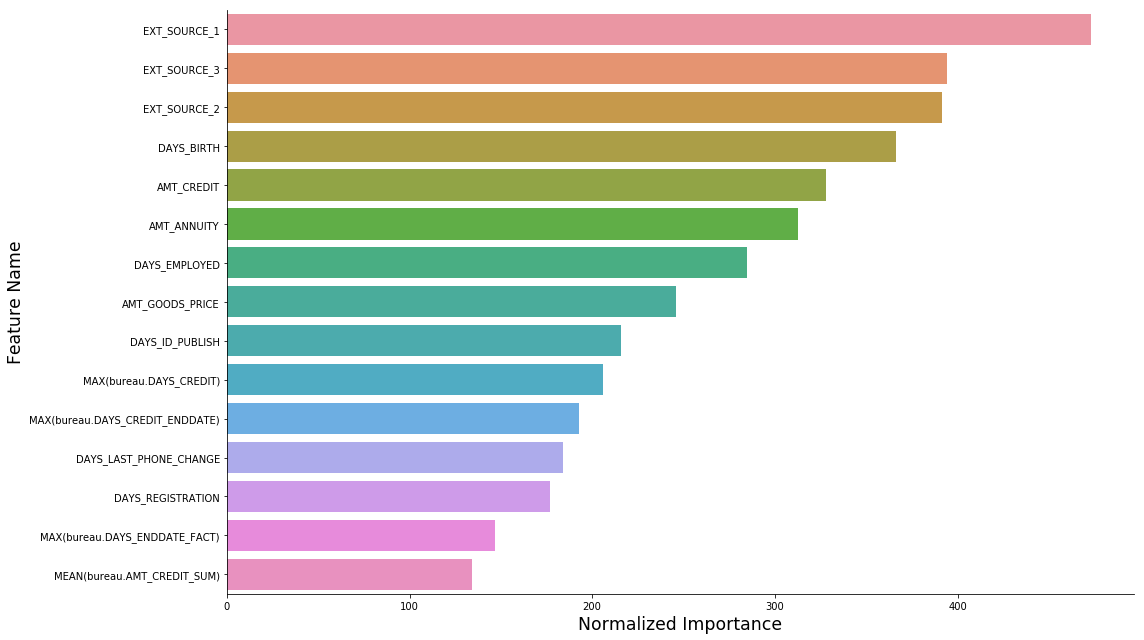

In [40]:
ftm1_feature_importances_sorted = plot_feature_importances(ftm1_feature_importances)

We can see from the sorted and plotted top 15 most important features that some of the aggregates that we've synthesized earlier have indeed held quite a significant weight. E.g. We see "MAX(bureau.DAYS_CREDIT)" in one of top 10 features.

<a id='06_03_dfs2'></a>
### 6.3 Trial #2: Deep Feature Synthesis (Entire Data Set)

The below cells proceed with adding the remaining tables and relations into our existing entity set, then re-running the same DFS procedure to generate our final super-set of features.

In [41]:
ft_es = ft_es.entity_from_dataframe(entity_id = 'previous_app', dataframe = raw_previous_application, index = 'SK_ID_PREV')
ft_es = ft_es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = raw_bureau_balance, make_index=True, index = 'bureau_balance_id')
ft_es = ft_es.entity_from_dataframe(entity_id = 'ccard_balance', dataframe = raw_credit_card_balance, make_index=True, index = 'ccard_balance_id')
ft_es = ft_es.entity_from_dataframe(entity_id = 'poscash_balance', dataframe = raw_POS_CASH_balance, make_index=True, index = 'poscash_balance_id')
ft_es = ft_es.entity_from_dataframe(entity_id = 'payments_balance', dataframe = raw_installments_payments, make_index=True, index = 'payments_balance_id')

ft_r_bureau_bureaubalance = ft.Relationship(ft_es['bureau']['SK_ID_BUREAU'], ft_es['bureau_balance']['SK_ID_BUREAU'])
ft_r_app_previousapp = ft.Relationship(ft_es['app']['SK_ID_CURR'], ft_es['previous_app']['SK_ID_CURR'])
ft_r_previousapp_ccard = ft.Relationship(ft_es['previous_app']['SK_ID_PREV'], ft_es['ccard_balance']['SK_ID_PREV'])
ft_r_previousapp_poscash = ft.Relationship(ft_es['previous_app']['SK_ID_PREV'], ft_es['poscash_balance']['SK_ID_PREV'])
ft_r_previousapp_payments = ft.Relationship(ft_es['previous_app']['SK_ID_PREV'], ft_es['payments_balance']['SK_ID_PREV'])

ft_es = ft_es.add_relationships([ft_r_bureau_bureaubalance, ft_r_app_previousapp, ft_r_previousapp_ccard, ft_r_previousapp_poscash, ft_r_previousapp_payments])

ft_es

Entityset: clients
  Entities:
    app [Rows: 356255, Columns: 123]
    bureau [Rows: 1716428, Columns: 17]
    previous_app [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    ccard_balance [Rows: 3840312, Columns: 24]
    poscash_balance [Rows: 10001358, Columns: 9]
    payments_balance [Rows: 13605401, Columns: 9]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous_app.SK_ID_CURR -> app.SK_ID_CURR
    ccard_balance.SK_ID_PREV -> previous_app.SK_ID_PREV
    poscash_balance.SK_ID_PREV -> previous_app.SK_ID_PREV
    payments_balance.SK_ID_PREV -> previous_app.SK_ID_PREV

In [42]:
# DFS with specified primitives
feature_names = ft.dfs(entityset = ft_es, target_entity = 'app',
                       trans_primitives=default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, features_only=True)

print('%d Total Features' % len(feature_names))

feature_matrix, feature_names = ft.dfs(entityset = ft_es, target_entity = 'app',
                                       trans_primitives=default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True, n_jobs=2)

display(feature_matrix.head(10))

859 Total Features
Built 859 features


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48926 remote=tcp://127.0.0.1:46399>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48928 remote=tcp://127.0.0.1:46399>


EntitySet scattered to workers in 170.956 seconds
Elapsed: 1:16:38 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


Exception ignored in: <generator object add_client at 0x7fac5e745d58>
RuntimeError: generator ignored GeneratorExit
tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/patanin_k/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,MAX(bureau.COUNT(bureau_balance)),MIN(bureau.SUM(bureau_balance.MONTHS_BALANCE)),MIN(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MIN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MIN(bureau.COUNT(bureau_balance)),MEAN(bureau.SUM(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MIN(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.COUNT(bureau_balance))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,20560.5,568800.0,450000.0,135000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.0,-1326.0,0.0,-25.5,2.0,-400.000000,0.0,-23.571429,-11.785714,24.571429
100002,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,22.0,-632.0,-32.0,-39.5,4.0,-337.625000,-15.5,-28.250000,-21.875000,13.750000
100003,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,0.000000
100004,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,0.000000
100005,17370.0,222768.0,180000.0,99000.0,0.0,0.0,0.0,0.0,0.0,3.0,...,13.0,-78.0,0.0,-6.0,3.0,-30.333333,0.0,-6.000000,-3.000000,7.000000
100006,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,0.000000
100008,27517.5,490495.5,454500.0,99000.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,0.000000
100009,41301.0,1560726.0,1395000.0,171000.0,0.0,0.0,1.0,1.0,0.0,2.0,...,0.0,0.0,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,0.000000


The above cell successfully ran, combining all of our raw data tables and generating the 

<a id='07_featureselect1'></a>
## 7.0 Feature Selection (Part 1)
---

With the new matrix of 859 fully engineered features, it would be complex and computationally exhaustive to fit the model over the entire feature-set. We need to perform some feature selections and remove some less significant features from this set to produce a more robust and less costly dataset. The different approaches we will perform for feature selection include:

- FeatureTools' `remove_low_information_features`
- Removing SK_ID related features
- Removing highly collinear pairs of features
- Removing low count/highly null features

Each step should expectedly help reduce the number of features from our set by a marginal amount.

<a id='07_01_ftremovelowinfo'></a>
### 7.1 FeatureTools `selection.remove_low_information_features`

Using the built in function `selection.remove_low_information_features` from our `FeatureTool` package helps single out any columns that contain less than 2 unique values and removes them the set. These features should technically add no value to our model as it does not even have enough unique values for the model to generate boundaries between.

In [43]:
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features' % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

feature_matrix2.shape

Removed 2 features


(356255, 857)

<a id='07_02_skidfeatures'></a>
### 7.2 Removing `SK_ID` Related Features

The next routine for us it to remove any columns relating or deriving from the SK_ID columns/data. Since these SK_ID values are just key values unique to each applicant, it should not have any signal-oriented information for us or the model to deduce from. Hence, the below cell loops through our set of features and takes out any features containing the 3 key IDs in its feature content.

In [44]:
cols_with_id = [x for x in feature_matrix2.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in feature_matrix2.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in feature_matrix2.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

feature_matrix2 = feature_matrix2.drop(columns = cols_with_id)
print('feature_matrix2 Shape: ', feature_matrix2.shape)

There are 51 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
feature_matrix2 Shape:  (356255, 806)


<a id='07_03_collinearity'></a>
### 7.3 Removing Collinearly Redundant Features

Collinearity is a big component in our dataset. Having run the automatic feature synthesis loop, it is natural that quite a few of our columnns would have been very closely related due to its common derivative value. The below cells go through the steps of:

1. Generating a full correlation matrix between the different features in the set.
2. Triangulating the correlation matrix for easier analysis of unique correlation pairs.
3. Dropping any columns containing a correlation value of at least the preset threshold, retaining the other feature in the pair.

In terms of collinearity threshold, we've decided to have the threshold at a conservatively high level of 0.95 as we want to make sure that as much information is still retained. I believe any loss of information in the context of the financial industry, especially with determining default risk, would be a sensitive loss, and hence believe we should keep our thresholds high.

In [45]:
# Set threshold collinearity to drop
collinear_threshold = 0.95

# Generate full correlation matrix of features
collinear_corr_matrix = feature_matrix2.corr().abs()
display(collinear_corr_matrix.head())

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,MAX(bureau.COUNT(bureau_balance)),MIN(bureau.SUM(bureau_balance.MONTHS_BALANCE)),MIN(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MIN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MIN(bureau.COUNT(bureau_balance)),MEAN(bureau.SUM(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MIN(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.COUNT(bureau_balance))
AMT_ANNUITY,1.000000,0.762521,0.768123,0.204391,0.001472,0.003162,0.029877,0.017053,0.009583,0.015458,...,0.133725,0.119900,0.006130,0.029819,0.107643,0.117685,0.004973,0.056308,0.042673,0.138341
AMT_CREDIT,0.762521,1.000000,0.987159,0.166590,0.005411,0.002333,0.058050,0.004341,0.002961,0.047656,...,0.007157,0.008296,0.082386,0.098616,0.005056,0.008325,0.058581,0.083501,0.091027,0.005928
AMT_GOODS_PRICE,0.768123,0.987159,1.000000,0.169445,0.005816,0.001688,0.059851,0.004691,0.003229,0.050080,...,0.006701,0.008822,0.082602,0.099874,0.005445,0.008590,0.058073,0.085278,0.092226,0.005652
AMT_INCOME_TOTAL,0.204391,0.166590,0.169445,1.000000,0.002743,0.000767,0.022736,0.006712,0.001447,0.011153,...,0.031954,0.032099,0.034303,0.068931,0.004558,0.019607,0.001695,0.027729,0.021332,0.023689
AMT_REQ_CREDIT_BUREAU_DAY,0.001472,0.005411,0.005816,0.002743,1.000000,0.227493,0.003313,0.005853,0.214474,0.003224,...,0.004859,0.002003,0.032861,0.022540,0.001081,0.000835,0.037823,0.003838,0.018962,0.003199


In [46]:
# Triangulate the generated correlation matrix
collinear_upper = collinear_corr_matrix.where(np.triu(np.ones(collinear_corr_matrix.shape), k=1).astype(np.bool))
display(collinear_upper.head())

# Identify any column containing at least one collinearity with value 0.95 or above
collinear_to_drop = [column for column in collinear_upper.columns if any(collinear_upper[column] > collinear_threshold)]
print(f'There are {len(collinear_to_drop)} columns to remove.')

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,MAX(bureau.COUNT(bureau_balance)),MIN(bureau.SUM(bureau_balance.MONTHS_BALANCE)),MIN(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MIN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MIN(bureau.COUNT(bureau_balance)),MEAN(bureau.SUM(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MIN(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.COUNT(bureau_balance))
AMT_ANNUITY,NaN,0.762521,0.768123,0.204391,0.001472,0.003162,0.029877,0.017053,0.009583,0.015458,...,0.133725,0.119900,0.006130,0.029819,0.107643,0.117685,0.004973,0.056308,0.042673,0.138341
AMT_CREDIT,NaN,NaN,0.987159,0.166590,0.005411,0.002333,0.058050,0.004341,0.002961,0.047656,...,0.007157,0.008296,0.082386,0.098616,0.005056,0.008325,0.058581,0.083501,0.091027,0.005928
AMT_GOODS_PRICE,NaN,NaN,NaN,0.169445,0.005816,0.001688,0.059851,0.004691,0.003229,0.050080,...,0.006701,0.008822,0.082602,0.099874,0.005445,0.008590,0.058073,0.085278,0.092226,0.005652
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.002743,0.000767,0.022736,0.006712,0.001447,0.011153,...,0.031954,0.032099,0.034303,0.068931,0.004558,0.019607,0.001695,0.027729,0.021332,0.023689
AMT_REQ_CREDIT_BUREAU_DAY,NaN,NaN,NaN,NaN,NaN,0.227493,0.003313,0.005853,0.214474,0.003224,...,0.004859,0.002003,0.032861,0.022540,0.001081,0.000835,0.037823,0.003838,0.018962,0.003199


There are 415 columns to remove.


In [47]:
# Drop identified features per collinearity analysis above
feature_matrix2 = feature_matrix2.drop(columns = collinear_to_drop)

print('feature_matrix2 Shape: ', feature_matrix2.shape)

feature_matrix2 Shape:  (356255, 391)


<a id='07_04_highnullfeatures'></a>
### 7.4 Removing High-Null-Density Features

Once we have all collinear features reduced, we are left with removing any features that do not contain enough values to provide a meaning sample for regression. Hence, we proceed to dropping any columns that contain values in less than a threshold proportion of data points, i.e. in this case if they do have values for less than 10% of our data points.

In [48]:
high_null_threshold = 0.90

ftm2_nulls = (feature_matrix2.isnull().sum()/len(feature_matrix2)).sort_values(ascending=False)

ftm2_nulls = ftm2_nulls.index[ftm2_nulls > high_null_threshold]

feature_matrix2 = feature_matrix2.drop(columns=ftm2_nulls)

In [49]:
print('feature_matrix2 Shape: ', feature_matrix2.shape)
display(feature_matrix2.head())

feature_matrix2 Shape:  (356255, 389)


,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,...,SUM(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MAX(bureau.SUM(bureau_balance.MONTHS_BALANCE)),MAX(bureau.COUNT(bureau_balance)),MIN(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MIN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MIN(bureau.COUNT(bureau_balance)),MEAN(bureau.SUM(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MAX(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.COUNT(bureau_balance))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,20560.5,568800.0,135000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0660,...,0.0,-1.0,52.0,0.0,-25.5,2.0,-400.000000,0.0,-11.785714,24.571429
100002,24700.5,406597.5,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,...,-124.0,-6.0,22.0,-32.0,-39.5,4.0,-337.625000,-15.5,-21.875000,13.750000
100003,35698.5,1293502.5,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,...,0.0,0.0,0.0,NaN,NaN,0.0,0.000000,NaN,NaN,0.000000
100004,6750.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,NaN,NaN,0.0,0.000000,NaN,NaN,0.000000
100005,17370.0,222768.0,99000.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,...,0.0,-3.0,13.0,0.0,-6.0,3.0,-30.333333,0.0,-3.000000,7.000000


In [50]:
print('Features By Types:')
print(feature_matrix2.dtypes.value_counts())
print()
print('Values per Object Feature:')
print(feature_matrix2.select_dtypes('object').apply(pd.Series.nunique, axis=0))

Features By Types:
float64    334
int64       38
object      17
dtype: int64

Values per Object Feature:
CODE_GENDER                    2
EMERGENCYSTATE_MODE            2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
RAW_SET                        2
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
dtype: int64


The outcome of our feature selection has been quite satisfactory. We were able to reduce the dataset down to less than half our originally feature engineered matrix, concluding at 391 features with only 17 of it being categorical. We will be sticking to this set of features for our final model fitting and tuning moving forward.

<a id='08_featuredtrain2'></a>
## 8. Trial #2: Model Fitting and Testing (Fully Feature Engineered Set)
---

Taking the now fully feature engineered and selected train/test set created from the above analyses, we then feed it through the LightGBM model once again to compare its score.

In [51]:
ftm2_train_encoded = feature_matrix2[(feature_matrix2['RAW_SET']=='train')]
ftm2_test_encoded = feature_matrix2[(feature_matrix2['RAW_SET']=='test')]
ftm2_train_encoded.drop(columns=['RAW_SET'], inplace=True)
ftm2_test_encoded.drop(columns=['RAW_SET'], inplace=True)

print(f'Features Matrix - Train = {ftm2_train_encoded.shape}')
print(f'Features Matrix - Test = {ftm2_test_encoded.shape}')

ftm2_train_encoded, ftm2_test_encoded = label_encode_train_test(ftm2_train_encoded, ftm2_test_encoded)
ftm2_train_encoded, ftm2_test_encoded = oh_encode_train_test(ftm2_train_encoded, ftm2_test_encoded)
ftm2_train_encoded, ftm2_test_encoded = align_columns_train_test(ftm2_train_encoded, ftm2_test_encoded)

ftm2_x_train, ftm2_x_test, ftm2_y_train, ftm2_y_test, ftm2_features_list = impute_scale_train_test(ftm2_train_encoded, ftm2_test_encoded)

ftm2_best_model, ftm2_metrics, ftm2_feature_importances, submission = run_model_lightgbm(ftm2_x_train,
                                                                                         ftm2_x_test,
                                                                                         raw_app_train['TARGET'],
                                                                                         ftm2_features_list,
                                                                                         lgb_strat_fold,
                                                                                         test_ids)

display(ftm2_metrics)

Features Matrix - Train = (307511, 388)
Features Matrix - Test = (48744, 388)
Label Encoding: CODE_GENDER
Label Encoding: EMERGENCYSTATE_MODE
Label Encoding: FLAG_OWN_CAR
Label Encoding: FLAG_OWN_REALTY
Label Encoding: NAME_CONTRACT_TYPE
5 columns were label encoded.
One-Hot Encoding Completed. Train Shape = (307511, 505). Test Shape = (48744, 504)
Train-Test Alignment Completed. Train Shape = (307511, 503). Test Shape = (48744, 503)


/home/patanin_k/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Median-Imputation and Min-Max Scaling completed:
x_train Shape = (307511, 502)
x_test Shape = (48744, 502)
y_train Shape = (307511,)
y_test Shape = (48744,)
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.777254	val's binary_logloss: 0.539897	train's auc: 0.825318	train's binary_logloss: 0.526002
[400]	val's auc: 0.779106	val's binary_logloss: 0.514775	train's auc: 0.861148	train's binary_logloss: 0.489616
Early stopping, best iteration is:
[366]	val's auc: 0.779382	val's binary_logloss: 0.518455	train's auc: 0.855861	train's binary_logloss: 0.495166
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.783911	val's binary_logloss: 0.535867	train's auc: 0.824786	train's binary_logloss: 0.526603
[400]	val's auc: 0.784558	val's binary_logloss: 0.511098	train's auc: 0.860625	train's binary_logloss: 0.490758
Early stopping, best iteration is:
[340]	val's auc: 0.784872	val's binary_logloss: 0.517695	train's auc: 0.85117	train's b

,fold,train,validate
0,0,0.855861,0.779382
1,1,0.851170,0.784872
2,2,0.859517,0.786207
3,3,0.842678,0.780202
4,4,0.862997,0.770868
5,overall,0.854445,0.780209


In [52]:
submission.to_csv('../output/HomeCreditDefaultRisk_Submit005_LightGbmFeaturedAll01.csv', index = False)

The submission was uplodaded to Kaggle on 2018/12/14 14:29. Test AUC Score = 0.77584.

We have clearly been able to obtain some marginal accuracy increases with the combined dataset and feature engineering.

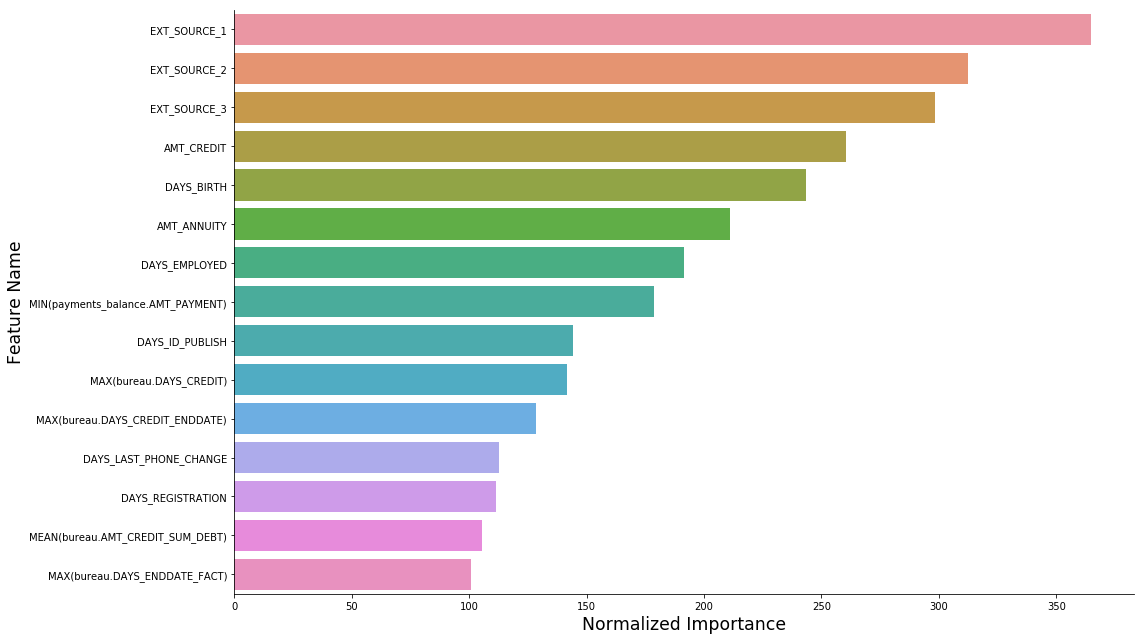

In [53]:
ftm2_feature_importances_sorted = plot_feature_importances(ftm2_feature_importances)

<a id='09_featureselect2'></a>
## 9. Feature Selection (Part 2): Zero-Importance Features
---

With the above final model completed, we are going to do one final feature selection where we remove any feature deemed irrelevant to the model. We derive this definition from our feature importances list; any feature returning with an importance or weight of zero will be taken out. This should help speed up our computations a bit further.

In [54]:
ftm2_features_zero_importance = ftm2_feature_importances[ftm2_feature_importances['importance']==0]

print(f'ftm2_features_zero_importance Shape = {ftm2_features_zero_importance.shape}')
display(ftm2_features_zero_importance.head())

ftm2_features_zero_importance Shape = (72, 2)


,feature,importance
28,FLAG_CONT_MOBILE,0.0
29,FLAG_DOCUMENT_10,0.0
31,FLAG_DOCUMENT_12,0.0
36,FLAG_DOCUMENT_17,0.0
38,FLAG_DOCUMENT_19,0.0


In [55]:
ftm3_train_encoded = ftm2_train_encoded.drop(columns = ftm2_features_zero_importance['feature'].values)

print(f'ftm3_train_encoded Shape = {ftm3_train_encoded.shape}')
display(ftm3_train_encoded.head())

ftm3_train_encoded Shape = (307511, 431)


,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,24700.5,406597.5,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,...,0,1,0,0,0,0,0,0,0,1
100003,35698.5,1293502.5,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,...,0,0,0,0,1,0,0,0,0,0
100004,6750.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0,0,0,0,1,0,0,0,0,0
100006,29686.5,312682.5,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
100007,21865.5,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0,0,0,0,0,0,0,1,0,0


In [56]:
ftm3_test_encoded = ftm2_test_encoded.copy()

ftm3_train_encoded, ftm3_test_encoded = align_columns_train_test(ftm3_train_encoded, ftm3_test_encoded)

Train-Test Alignment Completed. Train Shape = (307511, 431). Test Shape = (48744, 431)


We take the reduced matrix and fit it into our LightGBM model once more to return out a model and prediction for validation. 

In [57]:
ftm3_x_train, ftm3_x_test, ftm3_y_train, ftm3_y_test, ftm3_features_list = impute_scale_train_test(ftm3_train_encoded, ftm3_test_encoded)

ftm3_best_model, ftm3_metrics, ftm3_feature_importances, submission = run_model_lightgbm(ftm3_x_train,
                                                                                         ftm3_x_test,
                                                                                         raw_app_train['TARGET'],
                                                                                         ftm3_features_list,
                                                                                         lgb_strat_fold,
                                                                                         test_ids)

display(ftm3_metrics)

/home/patanin_k/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Median-Imputation and Min-Max Scaling completed:
x_train Shape = (307511, 430)
x_test Shape = (48744, 430)
y_train Shape = (307511,)
y_test Shape = (48744,)
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.777254	val's binary_logloss: 0.539897	train's auc: 0.825318	train's binary_logloss: 0.526002
[400]	val's auc: 0.779106	val's binary_logloss: 0.514775	train's auc: 0.861148	train's binary_logloss: 0.489616
Early stopping, best iteration is:
[366]	val's auc: 0.779382	val's binary_logloss: 0.518455	train's auc: 0.855861	train's binary_logloss: 0.495166
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.783911	val's binary_logloss: 0.535867	train's auc: 0.824786	train's binary_logloss: 0.526603
[400]	val's auc: 0.784411	val's binary_logloss: 0.511018	train's auc: 0.860789	train's binary_logloss: 0.490642
Early stopping, best iteration is:
[340]	val's auc: 0.784872	val's binary_logloss: 0.517695	train's auc: 0.85117	train's b

,fold,train,validate
0,0,0.855861,0.779382
1,1,0.851170,0.784872
2,2,0.859517,0.786207
3,3,0.842678,0.780202
4,4,0.863501,0.770903
5,overall,0.854546,0.780213


In [58]:
submission.to_csv('../output/HomeCreditDefaultRisk_Submit006_LightGbmFeaturedAll02.csv', index = False)

Submitted 2018/12/14 14:48. Test AUC Score = 0.0.77612.

Our model's accuracy has retained its full calibre after removing all the zero-importance features, validating the decision to reduce the matrix.

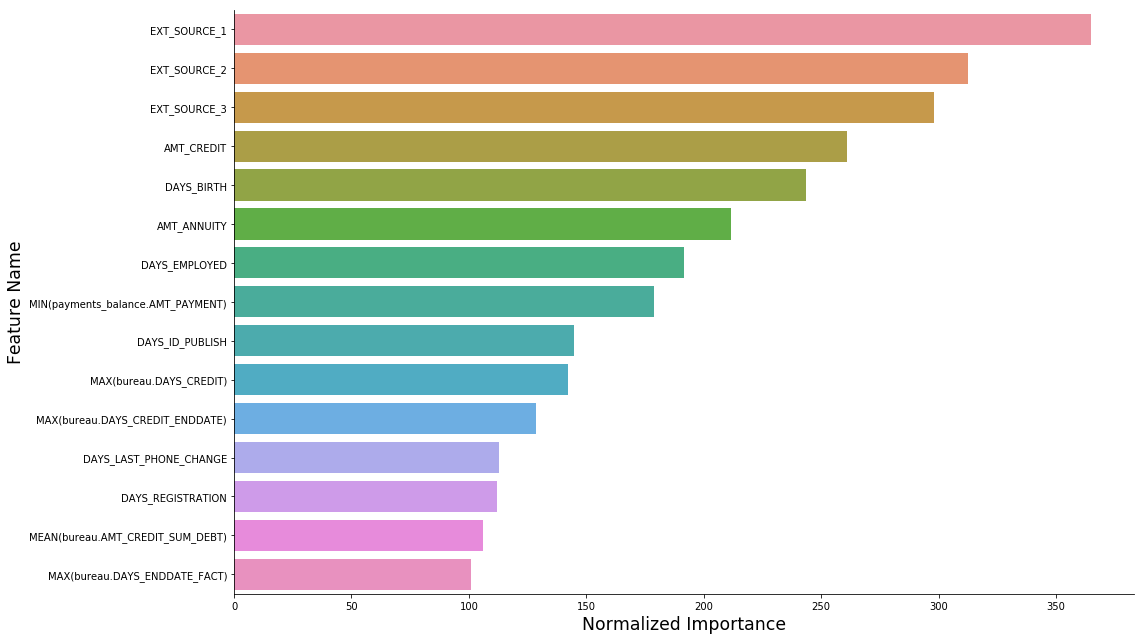

In [59]:
ftm3_feature_importances_sorted = plot_feature_importances(ftm3_feature_importances)

<a id='10_modeltuning'></a>
## 10. Model Tuning: Hyper Parameter Optimization
---

With feature engineering now completed and our model selection firm with LightGBM, we then proceed to the last step of our model build, tuning its hyper parameters for an optimal model parameter set. We will be using Grid-Search Cross-Validation as an initial trial, but may eventually retry with other forms of optimizers (e.g. `BayesSearchCV`) to compare for efficiency.

To reduce computation time of the grid search, we will be taking a subset of only 34% of the original train set data points. We will be running the gridsearch over this subset to get the optimal parameters, from which we will ultimately train a final model on the full train set and deliver a final test prediction with.

To select out the 34% data points, we will use our `train_test_split` with `test_size=0.66` to obtain the subset. We will also specify for stratification to ensure the imbalanced class proportion is maintained.

In [60]:
grid_x, dump_x, grid_y, dump_y = train_test_split(ftm3_x_train, raw_app_train['TARGET'], test_size=0.66, stratify=raw_app_train['TARGET'])

We proceed with building out our `GridSearchCV` object below. Given the time constraint for this project, we will be iterating through only the `learning_rate`, `num_leaves`, and `n_estimators`. Coming back to LightGBM's own documentation on [this page](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html "LightGBM Documentation: Parameters Tuning"), these three parameters may be key to increasing accuracy, hence our selection to test:

- <b>`learning_rate`</b>: Since we already started with a small value here to aim for high accuracy, we will try flanking numbers to see whether reducing it to an even smaller value or taking the other extreme to a very large value will improve our model or not
- <b>`num_estimators`</b>: Same here as the point above since both parameters had to be set hand-in-hand, we will see if smaller values can better improve our model instead
- <b>`num_leaves`</b>: This parameter was omitted earlier in our base model in fear of over-fitting. Hence, we will see if adjusting its value can help us. Given that LightGBM's default is 31, we will try flanking the value at 2 and 100 to see which direction can help us better predict our labels.

In [61]:
grid_cv_tuner = GridSearchCV(
    estimator = lgb.LGBMClassifier(        
        objective='binary',                        
        class_weight='balanced',
        reg_alpha=0.1,
        reg_lambda=0.1,
        subsample=0.85,
        n_jobs= -1,
        random_state=50
    ),
    param_grid = {
        'learning_rate': [0.01, 0.05, 1.0],
        'n_estimators': [10, 100, 10000],
        'num_leaves': [2, 31, 100]
    },    
    cv = 3,
    n_jobs = -1,
    scoring='accuracy',
    verbose = 2,
    refit = True
)

With the `GridSearchCV` object now created, we proceed to running the search and obtaining our best parameters and scores out of the search. Obtained results below did confirm that our `learning_rate` and `num_estimators` were already optimal, although `num_leaves` could still be tweaked with larger numbers (in this case the best was 100 from the search space).

In [62]:
grid_cv_tuner.fit(grid_x, grid_y)

print(grid_cv_tuner.best_params_)
print(grid_cv_tuner.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 145.8min finished


{'learning_rate': 0.05, 'n_estimators': 10000, 'num_leaves': 100}
0.9182615515575833


Using the above best parameters, we rebuild our LightGBM model, per below, with the newly found `num_leaves` set to 100. We will fit this model to our latest train/test set and use it for any end-result evaluations.

In [63]:
def run_best_model_lightgbm(lgb_x_train, lgb_x_test, lgb_y_train, feature_names, lgb_k_fold, test_ids):

    # declare variables to store results
    lgb_feature_importance = np.zeros(len(feature_names))
    test_predictions = np.zeros(lgb_x_test.shape[0])
    out_of_fold = np.zeros(lgb_x_train.shape[0])
    val_scores = []
    train_scores = []
    if type(lgb_k_fold)==type(KFold(2)):
        k_fold_iterator = lgb_k_fold.split(lgb_x_train)
    if type(lgb_k_fold)==type(StratifiedKFold(2)):
        k_fold_iterator = lgb_k_fold.split(lgb_x_train,lgb_y_train)

    # loop through each fold in the CV
    for train_points, val_points in k_fold_iterator:
        
        fold_x_train, fold_y_train = lgb_x_train[train_points], lgb_y_train.iloc[train_points]
        fold_x_val, fold_y_val = lgb_x_train[val_points], lgb_y_train.iloc[val_points]
        
        # Initiate LightGBM model
        model_lgb = lgb.LGBMClassifier(n_estimators=10000, objective='binary',
                                       class_weight='balanced', learning_rate=0.05,
                                       reg_alpha=0.1, reg_lambda=0.1,
                                       num_leaves=100,
                                       subsample=0.85, n_jobs= -1, random_state=50)

        # fit model to train
        model_lgb.fit(fold_x_train, fold_y_train, eval_metric = 'auc',
                      eval_set = [(fold_x_val, fold_y_val), (fold_x_train, fold_y_train)],
                      eval_names = ['val', 'train'], categorical_feature = 'auto',
                      early_stopping_rounds = 100, verbose = 200)

        # record best iteration and use model iteration to predict validate and test sets
        fold_best_iteration = model_lgb.best_iteration_
        lgb_feature_importance += model_lgb.feature_importances_ / lgb_k_fold.n_splits

        test_predictions += model_lgb.predict_proba(lgb_x_test, num_iteration=fold_best_iteration)[:, 1] / lgb_k_fold.n_splits
        out_of_fold[val_points] = model_lgb.predict_proba(fold_x_val, num_iteration=fold_best_iteration)[:, 1]

        val_score = model_lgb.best_score_['val']['auc']
        train_score = model_lgb.best_score_['train']['auc']
        
        val_scores.append(val_score)
        train_scores.append(train_score)
        
        # save current model if it returned the highest val score
        if val_score >= max(val_scores):
            lgb_best_model = model_lgb
        
        # clear previous fold's model from memory
        gc.enable()
        del model_lgb, fold_x_train, fold_x_val
        gc.collect()

    # output model scores from all folds
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    lgb_feature_importances = pd.DataFrame({'feature': feature_names, 'importance': lgb_feature_importance})

    val_auc = roc_auc_score(lgb_y_train, out_of_fold)

    val_scores.append(val_auc)
    train_scores.append(np.mean(train_scores))

    fold_names = list(range(n_folds))
    fold_names.append('overall')

    metrics = pd.DataFrame({'fold': fold_names,
                                'train': train_scores,
                                'validate': val_scores})

    return lgb_best_model, metrics, lgb_feature_importances, submission

In [64]:
ftm3_best_model, ftm3_metrics, ftm3_feature_importances, submission = run_best_model_lightgbm(ftm3_x_train,
                                                                                                    ftm3_x_test,
                                                                                                    raw_app_train['TARGET'],
                                                                                                    ftm3_features_list,
                                                                                                    lgb_strat_fold,
                                                                                                    test_ids)

display(ftm3_metrics)

Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.777507	val's binary_logloss: 0.48314	train's auc: 0.90496	train's binary_logloss: 0.443501
Early stopping, best iteration is:
[195]	val's auc: 0.777761	val's binary_logloss: 0.484594	train's auc: 0.903183	train's binary_logloss: 0.445858
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.782173	val's binary_logloss: 0.479711	train's auc: 0.904958	train's binary_logloss: 0.444227
Early stopping, best iteration is:
[178]	val's auc: 0.78259	val's binary_logloss: 0.486885	train's auc: 0.89605	train's binary_logloss: 0.455422
Training until validation scores don't improve for 100 rounds.
[200]	val's auc: 0.783555	val's binary_logloss: 0.483892	train's auc: 0.903994	train's binary_logloss: 0.445419
Early stopping, best iteration is:
[175]	val's auc: 0.78372	val's binary_logloss: 0.492266	train's auc: 0.894136	train's binary_logloss: 0.45793
Training until validation scores don't i

,fold,train,validate
0,0,0.903183,0.777761
1,1,0.896050,0.782590
2,2,0.894136,0.783720
3,3,0.903966,0.779045
4,4,0.898592,0.768839
5,overall,0.899186,0.778317


Resulting scores from our model fitting above has shown significant improvement on the train set but very minimal to neglible changes to the validate set, confirming that increasing our `num_leaves` indeed only boosted our over-fitting magnitude. We will submit a set of predictions on Test to the Kaggle board for validation of these scores.

In [65]:
submission.to_csv('../output/HomeCreditDefaultRisk_Submit007_LightGbmBest.csv', index = False)

Submission uploaded to Kaggle on 2018/12/16 14:52. Test AUC score = 0.77598.

Kaggle's score results solidifies our conclusion that increasing `num_leaves` did not help our model, but rather only increased over-fitting.

<a id='11_finalevaluation'></a>
## 11. Evaluating Final Model Results
---

In the section below, we perform some metric analyses and investigative visualizations on our final LightGBM model to evaluate how well our model actually faired and declare some insights we found from the model itself. However, do keep in mind that these evaluations were done using our train set data points as Kaggle does not publicize the test set's `TARGET` labels, hence making it impossible for use to evaluate with the test set itself.

In [66]:
lgb_train_predicted_y = ftm3_best_model.predict(ftm3_x_train)

In [67]:
lgb_train_predicted_proba = ftm3_best_model.predict_proba(ftm3_x_train)

<a id='11_01_aucplot'></a>
### 11.1 Plot: Receiver Operating Characteristic (ROC) / Area Under Curve (AUC)

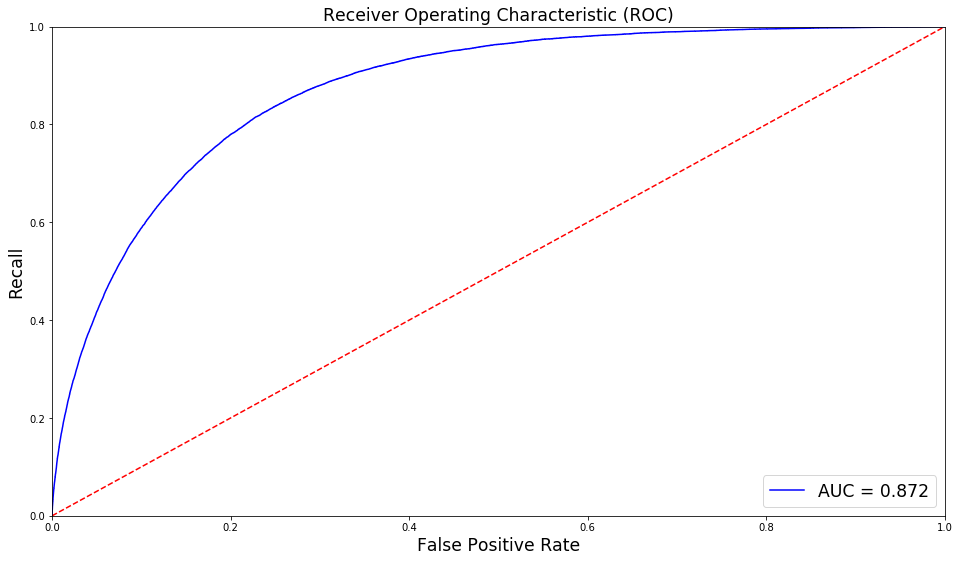

In [68]:
plt.figure(figsize=(16,9))
false_positive_rate, recall, thresholds = roc_curve(raw_app_train['TARGET'], lgb_train_predicted_proba[:,1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)',fontsize='xx-large')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.legend(loc='lower right',fontsize='xx-large')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall',fontsize='xx-large')
plt.xlabel('False Positive Rate',fontsize='xx-large')
plt.show()

Our model's ROC-AUC curve does show significant advantage over the random-guess curve, having a train-AUC at 0.872.

We plot out our confusion matrix below, again comparing against our train set data points.

<a id='11_02_confusionmatrix'></a>
### 11.2 Plot: Confusion Matrix

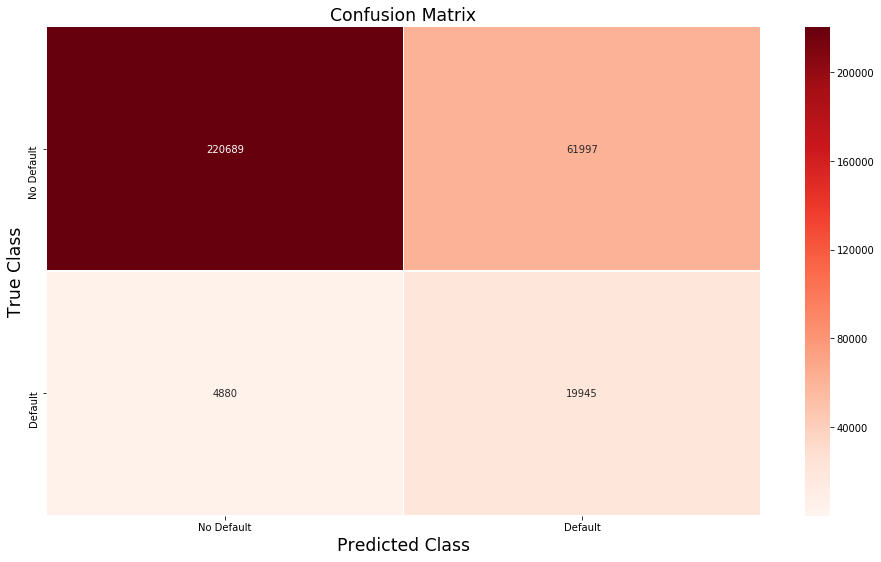

In [69]:
cm = confusion_matrix(raw_app_train['TARGET'], lgb_train_predicted_y)
labels = ['No Default', 'Default']
plt.figure(figsize=(16,9))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", vmin = 0.2, linewidths=.5)
plt.title('Confusion Matrix',fontsize='xx-large')
plt.ylabel('True Class',fontsize='xx-large')
plt.xlabel('Predicted Class',fontsize='xx-large')
plt.show()

The confusion matrix shows a heavy bias towards our false positives versus the false negative. This is considered good for our context of predicting default risk as we would rather commit a Type 1 Error where we mistaken mark someone incapable of repaying the loan, turning down possible business revenue, than committing the Type 2 Error where we mistakenly issue someone a loan where he/she then defaults on, incurring a large loss on the institution.

<a id='11_03_finalfeatureimportance'></a>
### 11.3 Plot: Model Feature Importances

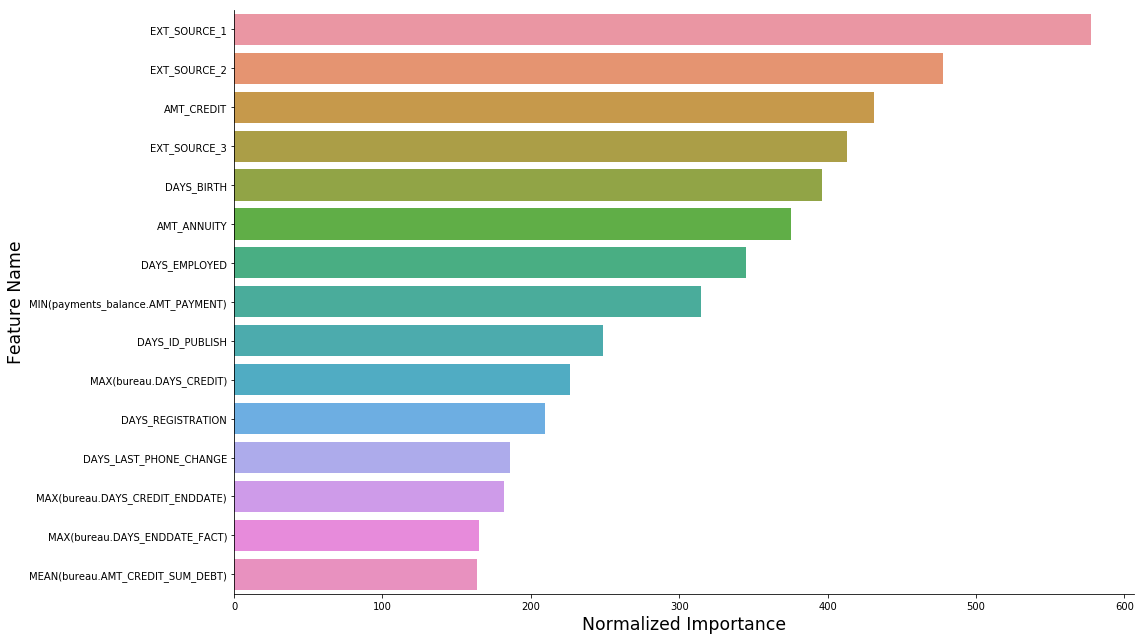

In [70]:
ftm3_feature_importances_sorted = plot_feature_importances(ftm3_feature_importances)

A quick plot of feature importances per above shows us that:

- The best estimators or most important features remain as `EXT_SOURCE_1` / `EXT_SOURCE_2` / `EXT_SOURCE_3`. These 3 features hold normalized scores of the applicant from external institutions, speculatively to be the big 3 credit bureaus - TransUnion, Equifax, and Experian. We can deduce from this fact that regardless of how much credit history you have, financial institution will still need to base their evaluation of your creditworthiness on these scores, if available.
- Not surprisingly, we see `AMT_CREDIT` and `AMT_ANNUITY` on the top as well, being the amount being asked for in the loan application and the amount of annuity to be set for the loan respectively.
- The most important demographic feature that is non-related to finance is `DAYS_BIRTH`, the age of the applicant. We will look further into this feature later in the evaluation.
- a few aggregate features did make it to the top of our feature importances, for instance `MIN(payments_balance.AMT_PAYMENT)` or the lowest amount you have ever paid for an installment in the case where a payment was made. This is quite expected given you would have records of small or minimal payment amounts if you are in a state where you struggle to meet the payment's demands.
- Interesting features that showed up in our top 15 were: `DAYS_ID_PUBLISH`, `DAYS_REGISTRATION`, `DAYS_LAST_PHONE_CHANGE`, all of which are metrics tracking the number of days since you last changed your ID documentation, registration, or phone. Upon speculation, we are expecting these features to serve like flags for default behavior, as someone looking to avoid collection may be making frequent efforts to change their identity or contact details.

With evaluation of the model complete per above, we then look into some of the top features listed and produce some key visualizations to realize the insights gained from these features. We will focus on the `EXTERNAL_SOURCE` scores as our top financial-related feature and the `DAYS_BIRTH` as our top non-financial feature.

<a id='11_04_externalsourcescores'></a>
### 11.4 Plot: `EXT_SOURCE` Scores

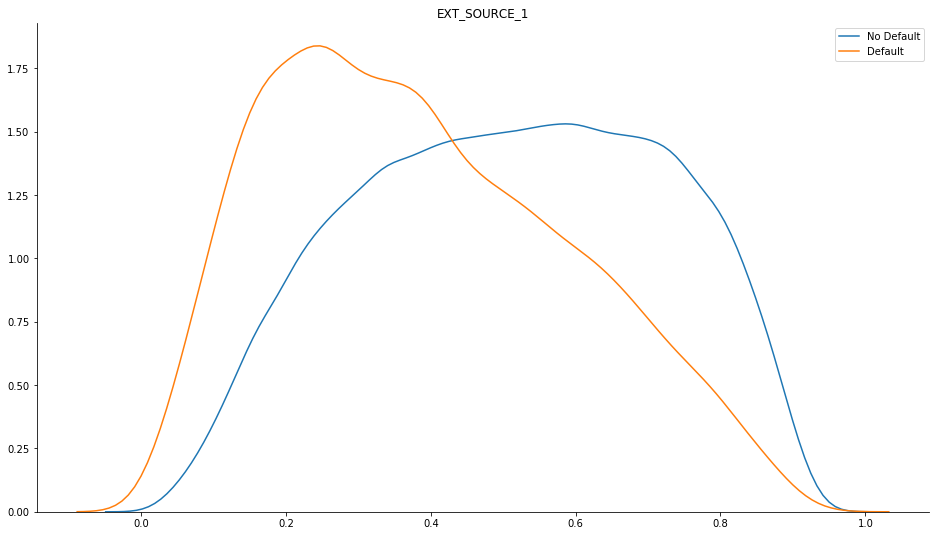

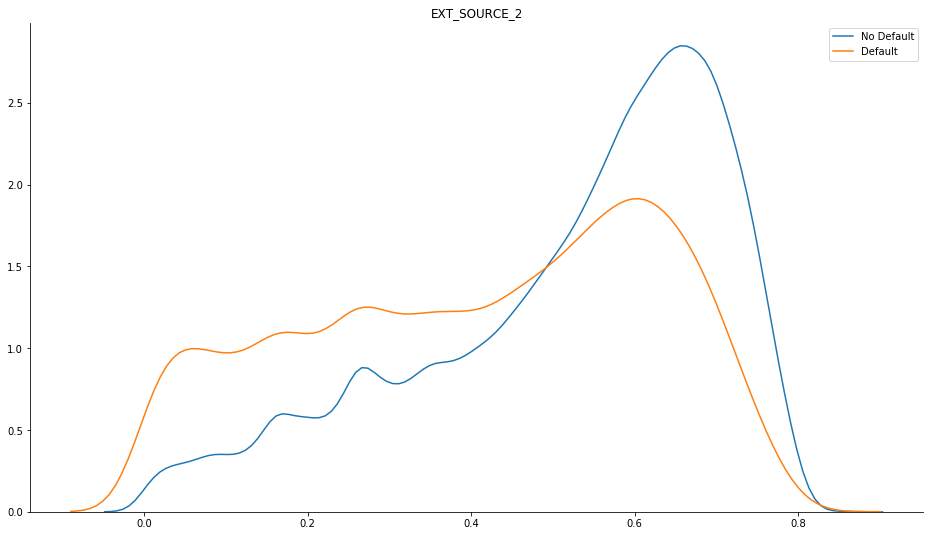

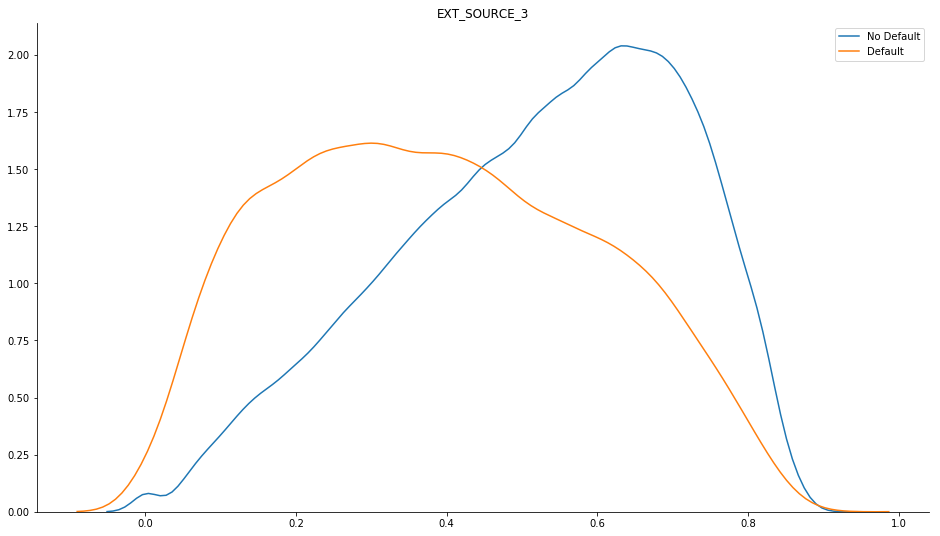

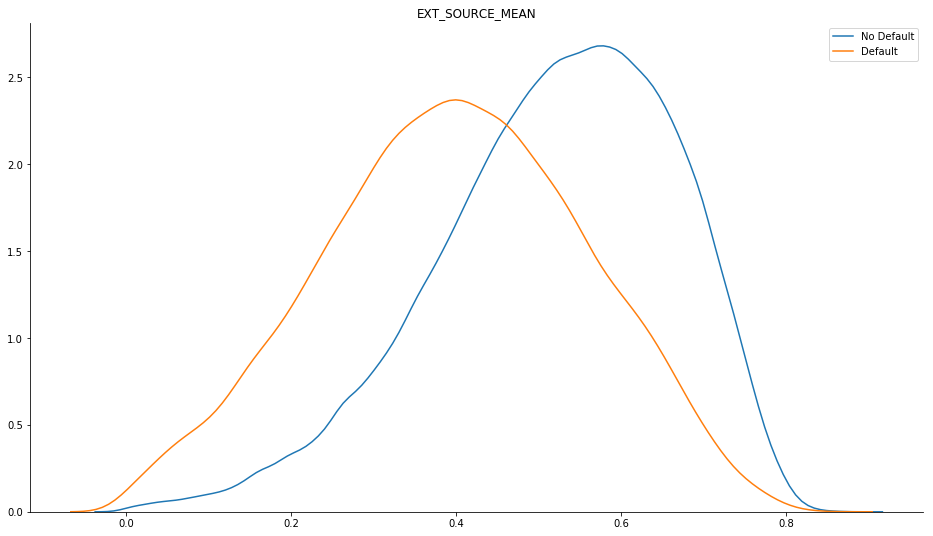

In [71]:
ext_source_means = raw_app_train.loc[:,['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].mean(axis=1)
ext_source_means = pd.concat([raw_app_train['TARGET'],pd.DataFrame(ext_source_means,columns=['EXT_SOURCE_MEAN'])],axis=1)

for plot_i in np.arange(3):
    plt.figure(figsize=(16,9))
    score_name = f'EXT_SOURCE_{plot_i+1}'
    sns.kdeplot(raw_app_train[(raw_app_train['TARGET']==0)][score_name], label='No Default')
    sns.kdeplot(raw_app_train[(raw_app_train['TARGET']==1)][score_name], label='Default')
    sns.despine()
    plt.title(score_name)
    plt.show()
    
plt.figure(figsize=(16,9))
sns.kdeplot(ext_source_means[(ext_source_means['TARGET']==0)]['EXT_SOURCE_MEAN'], label='No Default')
sns.kdeplot(ext_source_means[(ext_source_means['TARGET']==1)]['EXT_SOURCE_MEAN'], label='Default')
sns.despine()
plt.title('EXT_SOURCE_MEAN')
plt.show()


Taking plots of each `EXTERNAL_SOURCE` score and the aggregate mean clearly shows that the distribution of scores among those who default versus those who do not differ by quite a signifant gap. With the exception of `EXTERNAL_SOURCE_2` where the distributions are very similar but with the default population having a significantly larger proportion over the lower score ranges, the distribution of applicant over the score ranges seem to have single peaks with those who default having their peak at a much lower score than those who do not default.

<a id='11_05_agedistribution'></a>
### 11.5 Plot: Defaults over Age

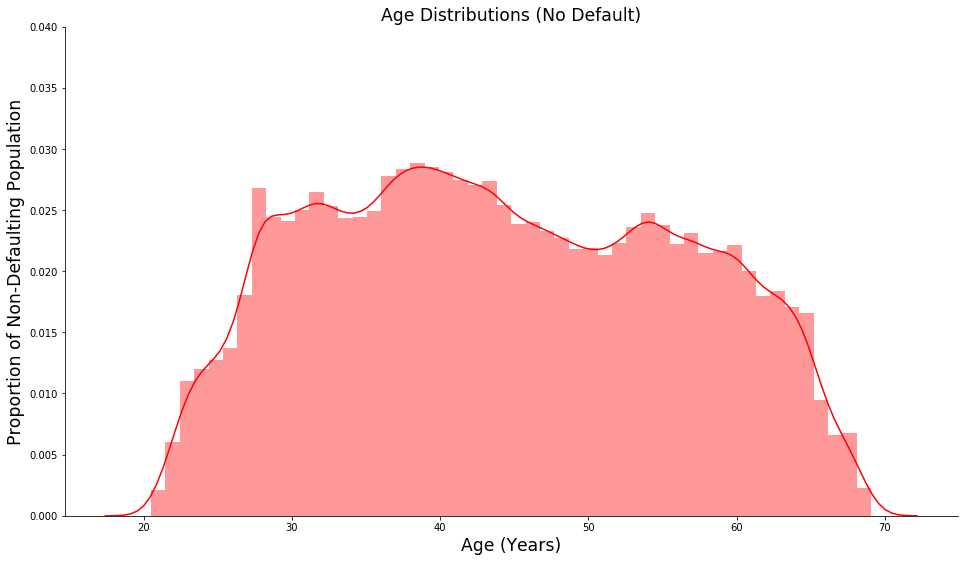

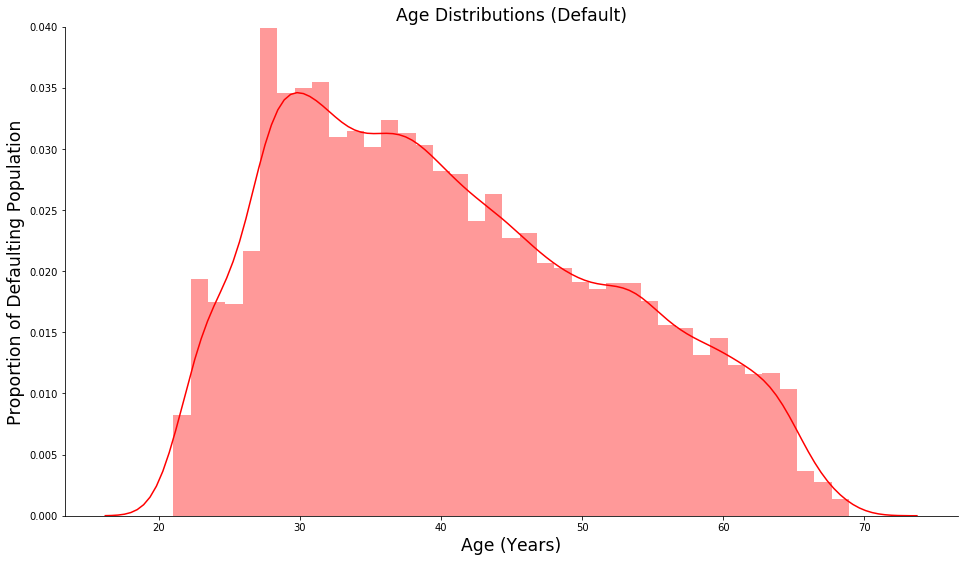

In [72]:
feature_name = 'DAYS_BIRTH'

plt.figure(figsize=(16,9))
sns.distplot(raw_app_train[(raw_app_train['TARGET']==0)][feature_name]*-1/365.25, label='No Default',color='Red')
sns.despine()
plt.ylabel('Proportion of Non-Defaulting Population',fontsize='xx-large')
plt.xlabel('Age (Years)',fontsize='xx-large')
plt.ylim(0,0.04)
plt.title('Age Distributions (No Default)',fontsize='xx-large')
plt.show()

plt.figure(figsize=(16,9))
sns.distplot(raw_app_train[(raw_app_train['TARGET']==1)][feature_name]*-1/365.25, label='Default',color='Red')
sns.despine()
plt.ylabel('Proportion of Defaulting Population',fontsize='xx-large')
plt.xlabel('Age (Years)',fontsize='xx-large')
plt.ylim(0,0.04)
plt.title('Age Distributions (Default)',fontsize='xx-large')
plt.show()

Our plot of age distributions show a much more pronounced difference. Among the population of non-defaults, we do not see any major trend or skewness to the the data, but the defaulting population is clearly right-skewed with a peak in the late 20s to early 30s age range. This resonates quite well with the business logic speculation that younger applicants are probably not financially stable and do pose a high risk to default. This risk then decreases gradually over time as one ages and consolidates wealth and financial stability over the years. We see a significant drop in defaults by around the mid-60s, likely at the typical age where the population generally retires and either no longer requires loans for their business or is now receiving pension payouts and relies less on loans.

<a id='12_futurework'></a>
## 12. Future Work / Plans
---

With the above analysis now concluded for the scope of our current capstone project, we list out possible future efforts to further enhance this model or close off any loose ends:

- <b>Manual Feature Engineering:</b> Although this project is a fully fledged financial modelling problem, I personally approached this project lacking the in-depth domain knowledge into the finance industry and resorted more generic and pure data science oriented techniques for the analysis. Although the process did turn us a fairly accurate model, applying manual feature engineering and calculating new features based on actual financial theories or metrics could have further boosted our model. Hence, should I have the time in the future and have obtained enough financial modelling expertise, I would like to revisit this analysis and further apply such features to test and compare against what we have produced so far. Example scenarios would be where I breakdown the framework of credit scores themselves (given `EXTERNAL_SOURCE` scores were our most important features) and manually add each of its own individual score components directly to my model (e.g. having a credit utilization ratio derived from the well-known FICO scoring system applied as a manual feature).

- <b>Model Ensembling/Stacking:</b> Throughout this model, we have extensively used the LightGBM model given its robustness and vast amounts of research and discussion supporting it as the best model for tabular data analysis. However, in referencing the Kaggle competition's own top leaderboard teams' presentations, they have clearly indicated usage of multiple level model stacking and ensembling to further boost their accuracy. Hence, should we have the capability to spare additional time for model once again, I will continue my analysis by attempting to fit other models, namely:

     - <b>XGBoost and CatBoost:</b> for contrast against the the LightGBM model given their similarities but with their own sets of advantages
     - <b>Neural Networks (TensorFlow):</b> there has been a lot of discussion around this wherein neural networks tend to not do as well as gradient boosted tree models in the context of tabular data, but I would like to try it out and see if we can stack it further on top of the boosted models to capture any losses.